# ETF Volatility Forecasting

# Context:

The volatility of a stock is a measure of how large the stock price changes, defined as the square-root of the variance of the returns. In modern portfolio theory, the volatility is used as a proxy for the risk associated with an investment: the higher the volatility, the higher the risk. 

Periods of large volatilities tend to be followed by more periods of large volatilities (and similarly for periods of small volatilities), giving rise to a phenomenon known as volatility clustering. Owing to this observation, volatilities in financial time series are modelled as having dependencies on their lagged values using the generalized autoregressive conditional heteroskedasticity (GARCH) models. 

In this project, we will use GARCH to model and forecast the volatilities of three Exchange-Traded Funds (ETFs) from three geographic regions, the United States, East Asia, and South-East Asia. Perhaps of note, our time series will include the 2020 stock market crash due to the COVID-19 pandemic.

# Goals: 

-  Model the volatilities of three ETFs localized in three geographic regions 
-  Forecast the next month's volatilities

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
import yfinance as yf

In [2]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import arch
from pmdarima.arima import ndiffs
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
sns.set_style("darkgrid")
sns.set(font_scale=2)

# Data reading

The three ETFs we will chose for this project is SPY, AIA, and ASEA. 

-  SPY (SPDR S&P 500 ETF Trust): tracks the S&P500 (500 largest companies listed on stock exchanges in the United States)
-  AIA (iShares Asia 50 ETF): tracks 50 of the largest Asian stocks -- heavily weighted towards East Asian companies
-  ASEA (Global X FTSE Southeast Asia ETF): tracks 40 of the largest South East Asian stocks

In [4]:
stock_list = ['SPY', 'AIA', 'ASEA']

In [5]:
SPY_df = yf.download('SPY', start="2018-01-01", end="2023-02-20")
SPY_df['SPY'] = 100 * (SPY_df['Close'].pct_change())
AIA_df = yf.download('AIA', start="2018-01-01", end="2023-02-20")
AIA_df['AIA'] = 100 * (AIA_df['Close'].pct_change())
ASEA_df = yf.download('ASEA', start="2018-01-01", end="2023-02-20")
ASEA_df['ASEA'] = 100 * (ASEA_df['Close'].pct_change())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


We will focus on the daily returns for each ETF:

In [6]:
SPY_df = SPY_df.drop(columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
AIA_df = AIA_df.drop(columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
ASEA_df = ASEA_df.drop(columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

In [7]:
daily_returns = SPY_df.join(AIA_df).join(ASEA_df)
daily_returns = daily_returns.drop(index='2018-01-02')

In [8]:
daily_returns.head()

,SPY,AIA,ASEA
Date,,,
2018-01-03,0.632516,1.052006,0.694037
2018-01-04,0.421483,0.381235,0.287187
2018-01-05,0.666407,0.671924,0.973655
2018-01-08,0.182869,0.029025,-0.170158
2018-01-09,0.226342,-0.188577,-0.227278


In [9]:
daily_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1291 entries, 2018-01-03 to 2023-02-17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     1291 non-null   float64
 1   AIA     1291 non-null   float64
 2   ASEA    1291 non-null   float64
dtypes: float64(3)
memory usage: 40.3 KB


In [10]:
daily_returns.describe()

,SPY,AIA,ASEA
count,1291.000000,1291.000000,1291.000000
mean,0.041414,0.005752,-0.001959
std,1.354523,1.594766,1.269320
min,-10.942374,-9.826591,-11.572225
25%,-0.527300,-0.877062,-0.597327
50%,0.072758,0.032447,0.000000
75%,0.722916,0.923722,0.631763
max,9.060326,11.676021,7.452830


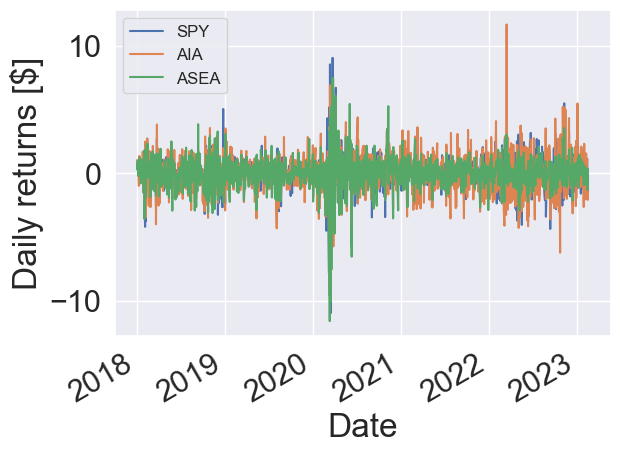

In [11]:
ax = daily_returns.plot(y=stock_list)
ax.legend(stock_list, fontsize=12)
plt.ylabel('Daily returns [$]')
plt.savefig('daily_returns', bbox_inches='tight')

Notice the spike in volatility in 2020, which is brought upon by COVID-19 pandemic.

# Data exploration

In [12]:
# Perform ADF and KPSS tests to find the differencing order
n_diffs = {}
for col_name in stock_list:
    kpss_diffs = ndiffs(daily_returns[col_name], alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(daily_returns[col_name], alpha=0.05, test='adf', max_d=6)
    n_diffs[col_name] = max(adf_diffs, kpss_diffs)
n_diffs

{'SPY': 0, 'AIA': 0, 'ASEA': 0}

After differencing, data is stationary, as indicated by the ADF and KPSS tests.

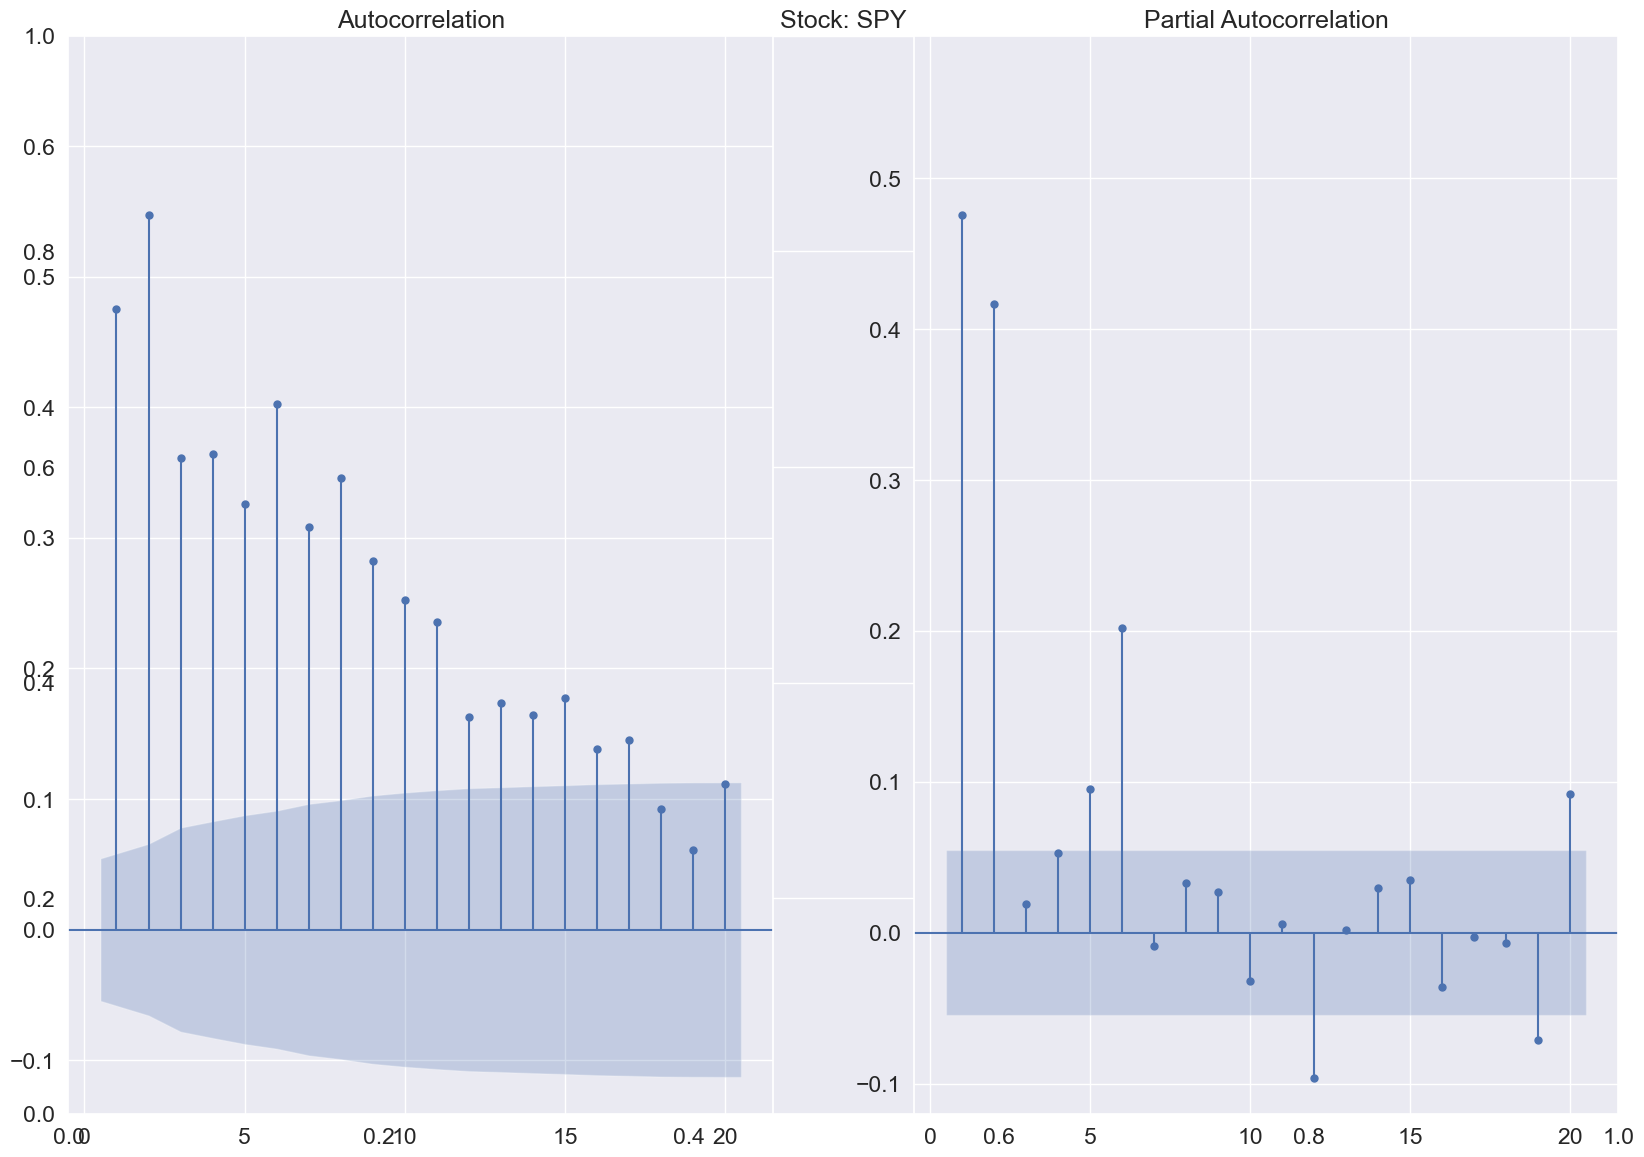

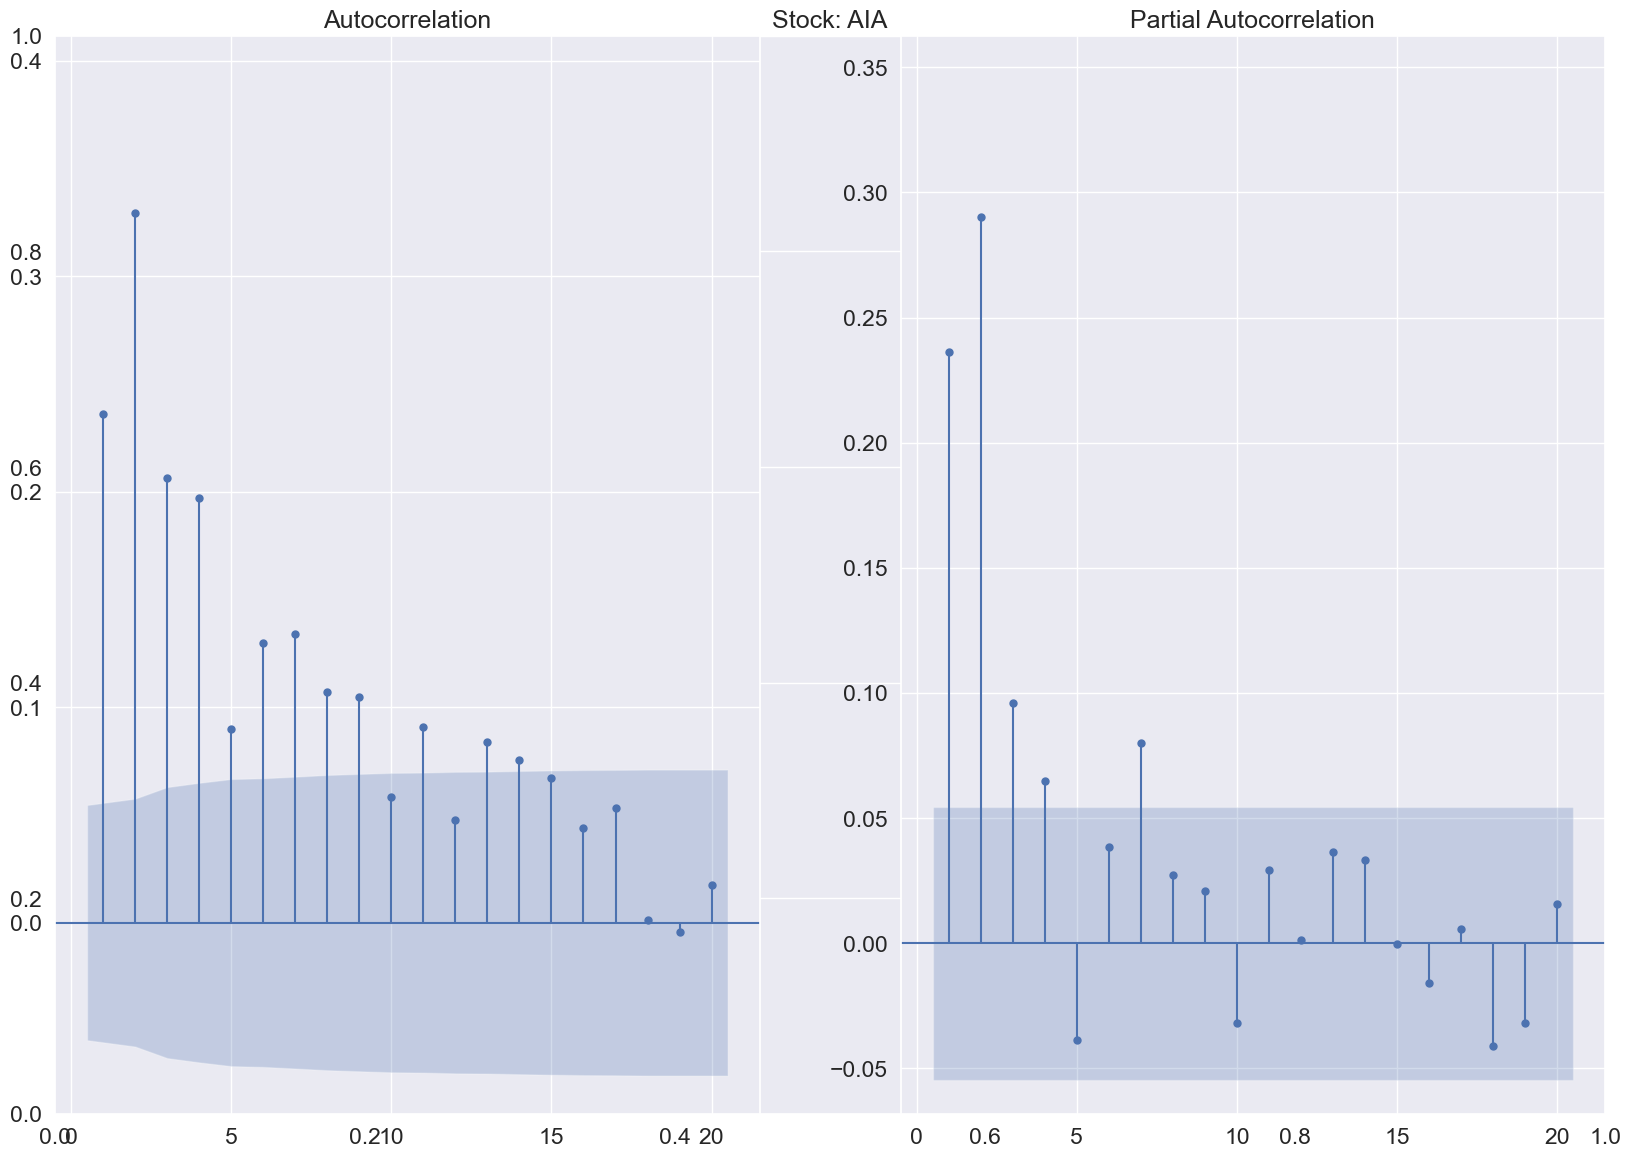

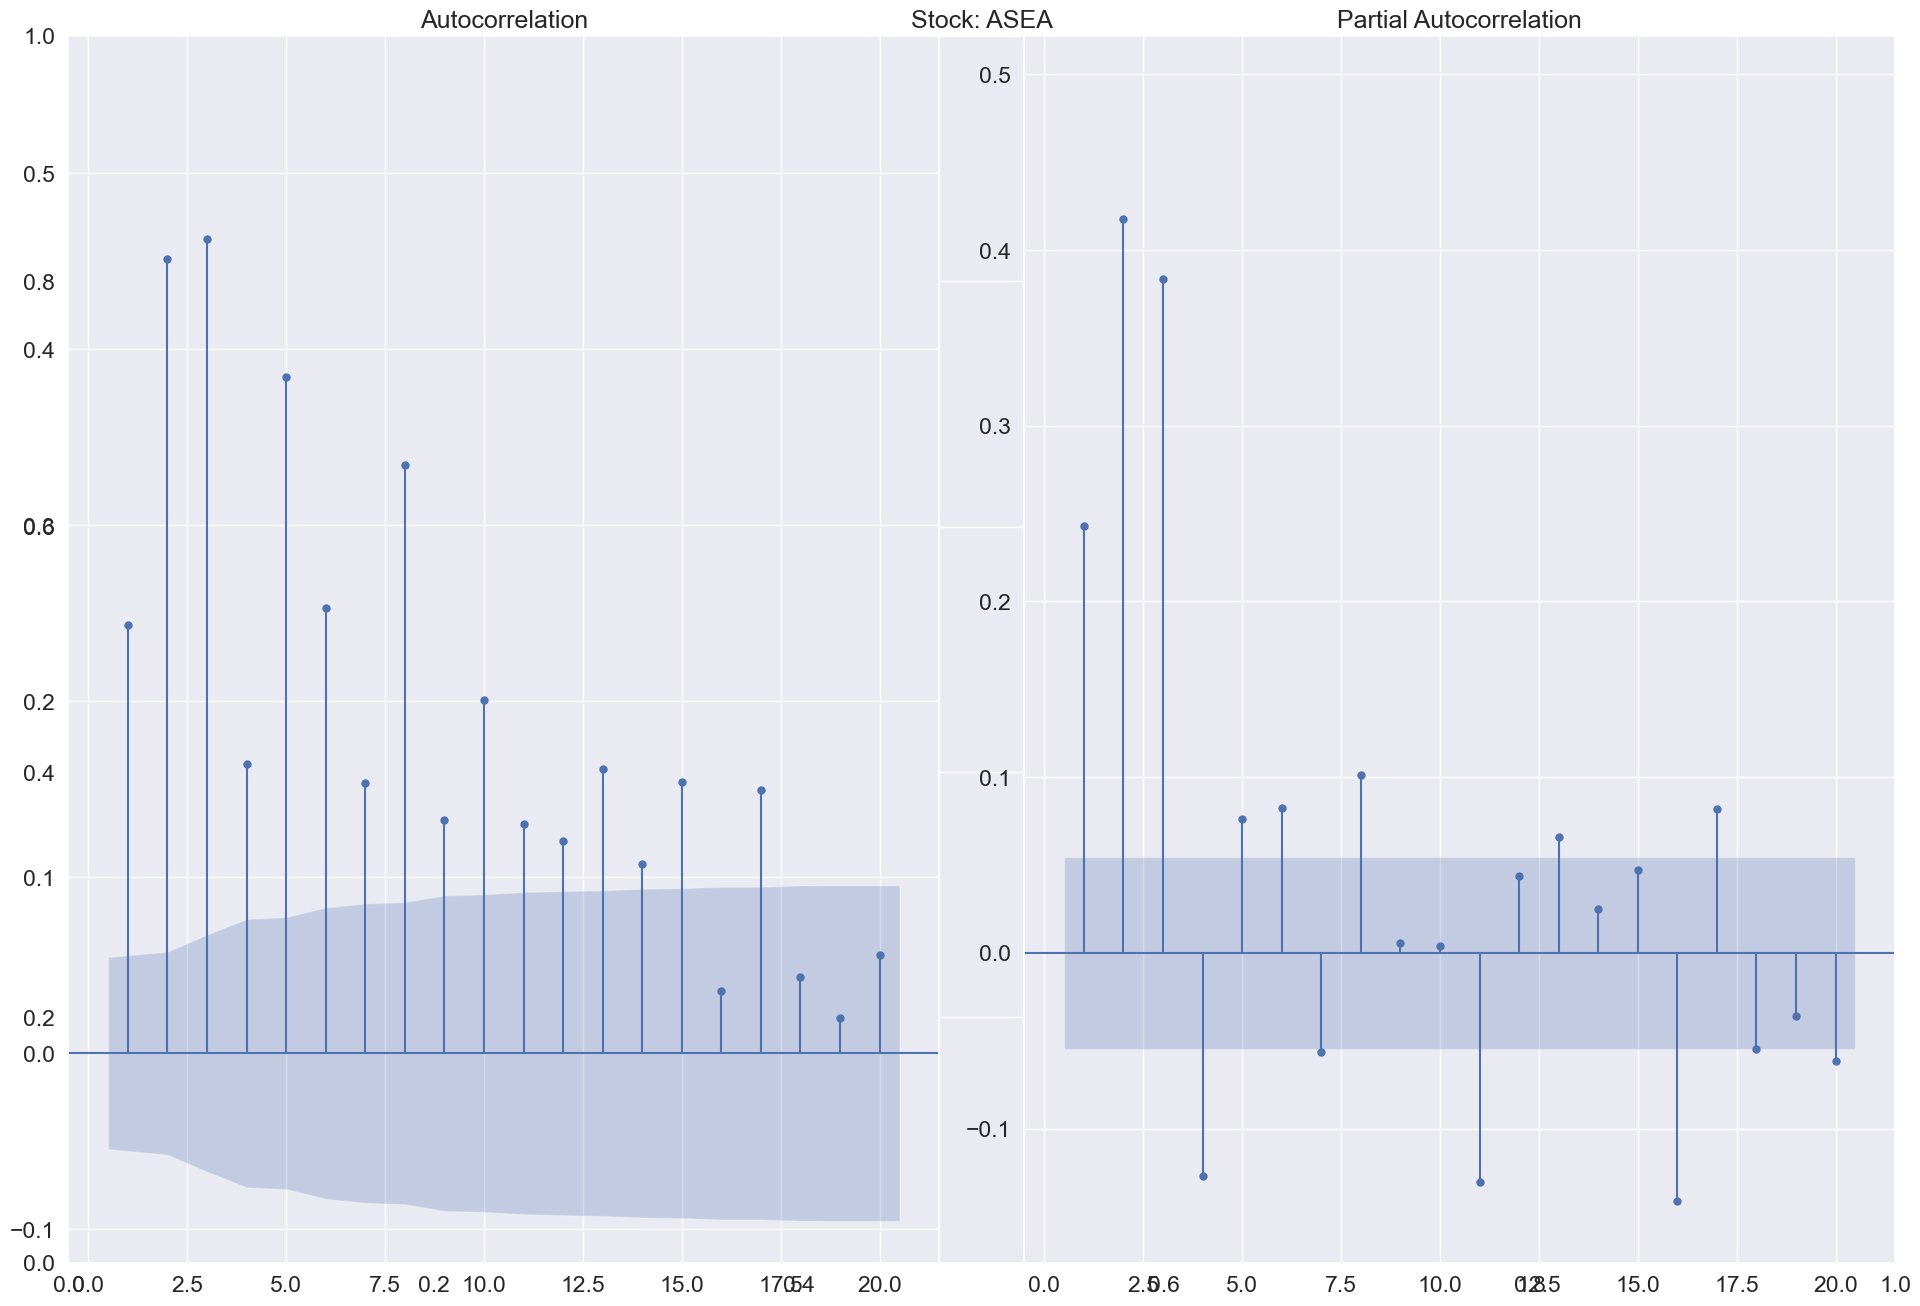

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.set(font_scale=1.5)
    for stock_name in stock_list:
        fig=plt.figure(figsize=(20,14))
        plot_name = 'Stock: ' + stock_name 
        plt.title(plot_name)
        axL=fig.add_subplot(121)
        acf_plot = sm.graphics.tsa.plot_acf(daily_returns[stock_name]**2,lags=20,ax=axL,
                                            zero=False, auto_ylims=True)
        axR=fig.add_subplot(122)
        pacf_plot = sm.graphics.tsa.plot_pacf(daily_returns[stock_name]**2,lags=20,ax=axR,
                                            zero=False, auto_ylims=True)
    fig.tight_layout()
    sns.set(font_scale=2)


# Volatility modelling with GARCH

## Normally distributed innovations

We have to decide on the GARCH(p,q) order parameters. Instead of manually guessing for the best order parameters, we will perform a grid search over them. The models with the lowest AIC will be chosen.

In [14]:
def find_garch_pq(series, max_p=5, max_q=5):
    ''' Grid search for minimum AIC '''
    current_lowest=(0,0,np.inf)
    aic_list = []
    for i in range(1,max_p+1,1):
        for j in range(max_q+1):
            model = arch.arch_model(series, p=i, q=j, vol='GARCH')
            res = model.fit()
            aic = res.aic
            if aic < current_lowest[2]:
                current_lowest = (i, j, aic)
            aic_list += [(i,j,aic)]
    return {'res':current_lowest, 'aic_list':aic_list}

In [15]:
pq_search = {}
for stock_name in stock_list:
    pq_search[stock_name] = find_garch_pq(daily_returns[stock_name])

Iteration:      1,   Func. Count:      5,   Neg. LLF: 7584.150416346112
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3636.24123873832
Iteration:      3,   Func. Count:     21,   Neg. LLF: 2305.417444306666
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2057.595452317581
Iteration:      5,   Func. Count:     30,   Neg. LLF: 2056.3266186347364
Iteration:      6,   Func. Count:     34,   Neg. LLF: 2056.166177268882
Iteration:      7,   Func. Count:     38,   Neg. LLF: 2056.1583184632364
Iteration:      8,   Func. Count:     42,   Neg. LLF: 2056.1582638453438
Iteration:      9,   Func. Count:     46,   Neg. LLF: 2056.158263258524
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2056.158263258524
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9541.43814104665
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7297.600880659781


Iteration:      4,   Func. Count:     30,   Neg. LLF: 14510.140050750508
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2558.960679701677
Iteration:      6,   Func. Count:     44,   Neg. LLF: 2212.0966718252357
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1947.3227679913975
Iteration:      8,   Func. Count:     59,   Neg. LLF: 1927.3478453924959
Iteration:      9,   Func. Count:     65,   Neg. LLF: 1926.5038309633967
Iteration:     10,   Func. Count:     71,   Neg. LLF: 1926.3755568073866
Iteration:     11,   Func. Count:     77,   Neg. LLF: 1926.3543761974488
Iteration:     12,   Func. Count:     83,   Neg. LLF: 1926.3462218915327
Iteration:     13,   Func. Count:     89,   Neg. LLF: 1926.3413184134122
Iteration:     14,   Func. Count:     95,   Neg. LLF: 1926.341136019808
Iteration:     15,   Func. Count:    101,   Neg. LLF: 1926.3410811260644
Iteration:     16,   Func. Count:    107,   Neg. LLF: 1926.3410796107091
Iteration:     17,   Func. Count:    112,   Neg. LLF:

Iteration:      1,   Func. Count:     11,   Neg. LLF: 7048.635860406507
Iteration:      2,   Func. Count:     25,   Neg. LLF: 1872961.6421332525
Iteration:      3,   Func. Count:     36,   Neg. LLF: 3150.532112084151
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2447.758152340155
Iteration:      5,   Func. Count:     58,   Neg. LLF: 2798.5106098620145
Iteration:      6,   Func. Count:     70,   Neg. LLF: 1981.0106536694516
Iteration:      7,   Func. Count:     81,   Neg. LLF: 1918.2293304667346
Iteration:      8,   Func. Count:     92,   Neg. LLF: 1887.9660966390325
Iteration:      9,   Func. Count:    103,   Neg. LLF: 1888.63462665713
Iteration:     10,   Func. Count:    114,   Neg. LLF: 1888.3523147372498
Iteration:     11,   Func. Count:    125,   Neg. LLF: 1887.9698006751405
Iteration:     12,   Func. Count:    136,   Neg. LLF: 1886.5208767183935
Iteration:     13,   Func. Count:    147,   Neg. LLF: 1889.4490356812616
Iteration:     14,   Func. Count:    158,   Neg. LLF: 18

Iteration:     16,   Func. Count:    196,   Neg. LLF: 1885.263924102131
Iteration:     17,   Func. Count:    207,   Neg. LLF: 1885.2637493622005
Iteration:     18,   Func. Count:    218,   Neg. LLF: 1885.2637223109575
Iteration:     19,   Func. Count:    229,   Neg. LLF: 1885.26372175228
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1885.26372175228
            Iterations: 19
            Function evaluations: 229
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     13,   Neg. LLF: 6702.764825818031
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1227715.9389961816
Iteration:      3,   Func. Count:     42,   Neg. LLF: 3534.005882890904
Iteration:      4,   Func. Count:     56,   Neg. LLF: 2561.4944475295215
Iteration:      5,   Func. Count:     69,   Neg. LLF: 2489.5864550058823
Iteration:      6,   Func. Count:     83,   Neg. LLF: 2464.5204522768922
Iteration:      7,   Func. Count:     96,   Neg. LLF: 2093.4768364

Iteration:      1,   Func. Count:      8,   Neg. LLF: 89925396485.32115
Iteration:      2,   Func. Count:     18,   Neg. LLF: 150503.23645843496
Iteration:      3,   Func. Count:     27,   Neg. LLF: 2429.9613226888177
Iteration:      4,   Func. Count:     37,   Neg. LLF: 2326.002551064965
Iteration:      5,   Func. Count:     46,   Neg. LLF: 2322.644174260051
Iteration:      6,   Func. Count:     54,   Neg. LLF: 2312.7891606877497
Iteration:      7,   Func. Count:     62,   Neg. LLF: 2312.605732537427
Iteration:      8,   Func. Count:     70,   Neg. LLF: 2312.4414236876983
Iteration:      9,   Func. Count:     77,   Neg. LLF: 2312.440766044402
Iteration:     10,   Func. Count:     84,   Neg. LLF: 2312.4407523940063
Iteration:     11,   Func. Count:     90,   Neg. LLF: 2312.4407523940663
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2312.4407523940063
            Iterations: 11
            Function evaluations: 90
            Gradient evaluati

Iteration:     18,   Func. Count:    215,   Neg. LLF: 2311.3741404785815
Iteration:     19,   Func. Count:    226,   Neg. LLF: 2311.3741119887927
Iteration:     20,   Func. Count:    237,   Neg. LLF: 2311.37410902344
Iteration:     21,   Func. Count:    247,   Neg. LLF: 2311.3741090232834
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2311.37410902344
            Iterations: 21
            Function evaluations: 247
            Gradient evaluations: 21
Iteration:      1,   Func. Count:      8,   Neg. LLF: 5395.963701919141
Iteration:      2,   Func. Count:     18,   Neg. LLF: 5382.3822761590345
Iteration:      3,   Func. Count:     28,   Neg. LLF: 91077.84581721402
Iteration:      4,   Func. Count:     36,   Neg. LLF: 19018.556648231217
Iteration:      5,   Func. Count:     44,   Neg. LLF: 4537.7218293980095
Iteration:      6,   Func. Count:     52,   Neg. LLF: 5081.213723488103
Iteration:      7,   Func. Count:     60,   Neg. LLF: 3010.1747201

Iteration:     14,   Func. Count:    139,   Neg. LLF: 2312.54904207812
Iteration:     15,   Func. Count:    148,   Neg. LLF: 2312.549040607496
Iteration:     16,   Func. Count:    156,   Neg. LLF: 2312.5490406076206
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2312.549040607496
            Iterations: 16
            Function evaluations: 156
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     11,   Neg. LLF: 5465.087995324793
Iteration:      2,   Func. Count:     24,   Neg. LLF: 162385.04857522855
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2400.0648394212117
Iteration:      4,   Func. Count:     47,   Neg. LLF: 2377.217446105683
Iteration:      5,   Func. Count:     58,   Neg. LLF: 2862615.9638448227
Iteration:      6,   Func. Count:     70,   Neg. LLF: 2389.613906585333
Iteration:      7,   Func. Count:     81,   Neg. LLF: 2401.4833848633093
Iteration:      8,   Func. Count:     92,   Neg. LLF: 2342.6931041

Iteration:     10,   Func. Count:     81,   Neg. LLF: 1914.373633147071
Iteration:     11,   Func. Count:     90,   Neg. LLF: 1910.185159422816
Iteration:     12,   Func. Count:     97,   Neg. LLF: 1910.1544151986525
Iteration:     13,   Func. Count:    104,   Neg. LLF: 1910.1420155697328
Iteration:     14,   Func. Count:    111,   Neg. LLF: 1910.140170662893
Iteration:     15,   Func. Count:    118,   Neg. LLF: 1910.1399814761248
Iteration:     16,   Func. Count:    125,   Neg. LLF: 1910.1399670354797
Iteration:     17,   Func. Count:    131,   Neg. LLF: 1910.1399670350766
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1910.1399670354797
            Iterations: 17
            Function evaluations: 131
            Gradient evaluations: 17
Iteration:      1,   Func. Count:      9,   Neg. LLF: 8812610473.415318
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3140591491.645505
Iteration:      3,   Func. Count:     29,   Neg. LLF: 2006.58261

Iteration:     10,   Func. Count:     85,   Neg. LLF: 1910.2655033472577
Iteration:     11,   Func. Count:     92,   Neg. LLF: 1910.265501347826
Iteration:     12,   Func. Count:     98,   Neg. LLF: 1910.265501347928
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1910.265501347826
            Iterations: 12
            Function evaluations: 98
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      9,   Neg. LLF: 763498145.055335
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5113.362754493359
Iteration:      3,   Func. Count:     30,   Neg. LLF: 2405.9932379318316
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2001.0089188705138
Iteration:      5,   Func. Count:     49,   Neg. LLF: 1942.8718491948066
Iteration:      6,   Func. Count:     58,   Neg. LLF: 1911.0122594861402
Iteration:      7,   Func. Count:     66,   Neg. LLF: 1925.7678667530158
Iteration:      8,   Func. Count:     75,   Neg. LLF: 1921.3005304

Iteration:     18,   Func. Count:    197,   Neg. LLF: 1906.7968747388686
Iteration:     19,   Func. Count:    207,   Neg. LLF: 1906.7968740753995
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1906.7968740753995
            Iterations: 19
            Function evaluations: 207
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     12,   Neg. LLF: 13587857772.039576
Iteration:      2,   Func. Count:     25,   Neg. LLF: 2174993062.9984107
Iteration:      3,   Func. Count:     38,   Neg. LLF: 2734.526041333789
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1964.6636448524841
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2043.8516930684634
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1945.2357189872887
Iteration:      7,   Func. Count:     86,   Neg. LLF: 1960.2073294810923
Iteration:      8,   Func. Count:     99,   Neg. LLF: 1915.5063331984306
Iteration:      9,   Func. Count:    111,   Neg. LLF: 1928.6

Iteration:      8,   Func. Count:    107,   Neg. LLF: 1944.785198570156
Iteration:      9,   Func. Count:    121,   Neg. LLF: 1936.7870800765836
Iteration:     10,   Func. Count:    134,   Neg. LLF: 1916.3190912675382
Iteration:     11,   Func. Count:    147,   Neg. LLF: 1909.644507151098
Iteration:     12,   Func. Count:    159,   Neg. LLF: 1935.336601461061
Iteration:     13,   Func. Count:    173,   Neg. LLF: 1916.6321177381917
Iteration:     14,   Func. Count:    186,   Neg. LLF: 1908.9403825803608
Iteration:     15,   Func. Count:    198,   Neg. LLF: 1908.9616042699477
Iteration:     16,   Func. Count:    211,   Neg. LLF: 1908.8913322144858
Iteration:     17,   Func. Count:    223,   Neg. LLF: 1908.8904784388767
Iteration:     18,   Func. Count:    235,   Neg. LLF: 1908.8896233695348
Iteration:     19,   Func. Count:    247,   Neg. LLF: 1908.8894947030233
Iteration:     20,   Func. Count:    259,   Neg. LLF: 1908.889478793478
Iteration:     21,   Func. Count:    271,   Neg. LLF: 1

Let us print out the results of the grid search!

In [16]:
for stock_name in stock_list:
    print('Result of grid search for GARCH order for stock ' + stock_name + ' is:')
    print(pq_search[stock_name]['res'])

Result of grid search for GARCH order for stock SPY is:
(1, 1, 3782.149012808167)
Result of grid search for GARCH order for stock AIA is:
(2, 1, 4635.0980821119565)
Result of grid search for GARCH order for stock ASEA is:
(1, 1, 3828.5310027050864)


In [17]:
pq_list = {'SPY': (1,1), 'AIA':(2,1), 'ASEA':(1,1)}
models = {}
for stock_name in stock_list:
    print('Now doing analysis for stock: ' + stock_name)
    model = arch.arch_model(daily_returns[stock_name], p = pq_list[stock_name][0], q = pq_list[stock_name][1], vol = 'GARCH')
    res = model.fit()
    models[stock_name] = [model,res]

Now doing analysis for stock: SPY
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9541.43814104665
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7297.600880659781
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2367.5511806990007
Iteration:      4,   Func. Count:     32,   Neg. LLF: 1887.7119010442707
Iteration:      5,   Func. Count:     38,   Neg. LLF: 9800.118184067407
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1887.1063137648284
Iteration:      7,   Func. Count:     51,   Neg. LLF: 1887.0745672301864
Iteration:      8,   Func. Count:     56,   Neg. LLF: 1887.0745064040834
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1887.0745064039586
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1887.0745064040834
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9
Now doing analysis for stock: AIA
Iteration:      1,   Func. Count:      7,   Neg. LLF: 5523.420093874595

In [18]:
models['AIA'][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    AIA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2312.55
Distribution:                  Normal   AIC:                           4635.10
Method:            Maximum Likelihood   BIC:                           4660.91
                                        No. Observations:                 1291
Date:                Sun, Mar 26 2023   Df Residuals:                     1290
Time:                        20:49:38   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0284  3.730e-02      0.762      0.446 [-4.467e-02,  0.102]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1843  8.086e-02      2.279  2.265e-02  [2.583e-02,  0.343]
alpha[1]       0.0978  4.151e-02      2.356  1.847e-02  [1.644e-02,  0.179]
alpha[2]       0.0794  7.060e-02      1.124      0.261 [-5.901e-02,  0.218]
beta[1]        0.7519  7.490e-02     10.039  1.023e-23    [  0.605,  0.899]
===========================================================================

Covariance estimator: robust
"""

The alpha[2] parameter for AIA is not significant, we can remove it and fit it with GARCH(1,1) instead. Note that the AIC for GARCH(1,1) and GARCH(2,1) is quite close. Let's replace the pq_list to:

In [19]:
pq_list = {'SPY': (1,1), 'AIA':(1,1), 'ASEA':(1,1)}

In [20]:
model = arch.arch_model(daily_returns['AIA'], p = pq_list['AIA'][0], q = pq_list['AIA'][1], vol = 'GARCH')
res = model.fit()
models['AIA'] = [model,res]
models['AIA'][1].summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6823.361266138874
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2504.029048118399
Iteration:      3,   Func. Count:     20,   Neg. LLF: 624570600.2602422
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2337.487190678593
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2324.0417207675355
Iteration:      6,   Func. Count:     38,   Neg. LLF: 2405.386631332354
Iteration:      7,   Func. Count:     44,   Neg. LLF: 2314.0999009868196
Iteration:      8,   Func. Count:     49,   Neg. LLF: 2313.9713188838114
Iteration:      9,   Func. Count:     54,   Neg. LLF: 2313.967995806587
Iteration:     10,   Func. Count:     59,   Neg. LLF: 2313.9654592876395
Iteration:     11,   Func. Count:     64,   Neg. LLF: 2313.965428211487
Iteration:     12,   Func. Count:     69,   Neg. LLF: 2313.9654269920206
Iteration:     13,   Func. Count:     73,   Neg. LLF: 2313.96542699203
Optimization terminated successfully    (Exit mode 0)
      

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    AIA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2313.97
Distribution:                  Normal   AIC:                           4635.93
Method:            Maximum Likelihood   BIC:                           4656.58
                                        No. Observations:                 1291
Date:                Sun, Mar 26 2023   Df Residuals:                     1290
Time:                        20:49:38   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0286  3.752e-02      0.763      0.445 [-4.491e-02,  0.102]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1364  4.809e-02      2.836  4.561e-03 [4.215e-02,  0.231]
alpha[1]       0.1438  3.274e-02      4.390  1.132e-05 [7.958e-02,  0.208]
beta[1]        0.8043  3.965e-02     20.285  1.758e-91   [  0.727,  0.882]
==========================================================================

Covariance estimator: robust
"""

We can overplot the modelled volatilities over the daily returns:

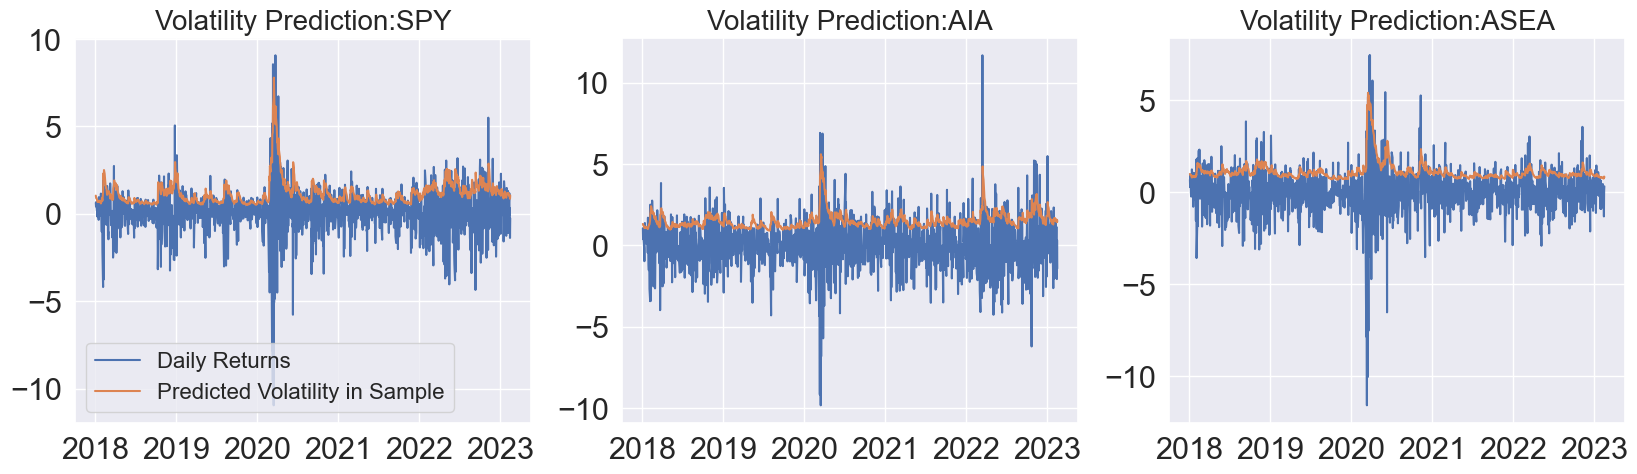

In [21]:
fig=plt.figure(figsize=(20,5))
for index, stock_name in enumerate(stock_list):
    fig.add_subplot(1,3,index+1)
    vol_model = models[stock_name][1].conditional_volatility
    daily_returns_plot = plt.plot(daily_returns[stock_name])
    vol_model_plot = plt.plot(vol_model)
    plt.title('Volatility Prediction:' + stock_name, fontsize=20)
    if stock_name == 'SPY':
        plt.legend(['Daily Returns', 'Predicted Volatility in Sample'], fontsize=16)

### Normally distributed innovations: residual diagnostics

To make sure that our models are appropriate, we will take a look at the residuals of the fit. We will do this in three ways: 
1) plotting the ACF and PACF plots of the squared standarized residuals
2) performing the Ljung-Box test on the squared standarized residuals 
3) plotting the histogram of the standarized residuals 

By looking at the ACF and PACF plots on the squared standarized residuals, we can see whether there are still GARCH effects in the residuals that is not modelled by our chosen GARCH models.

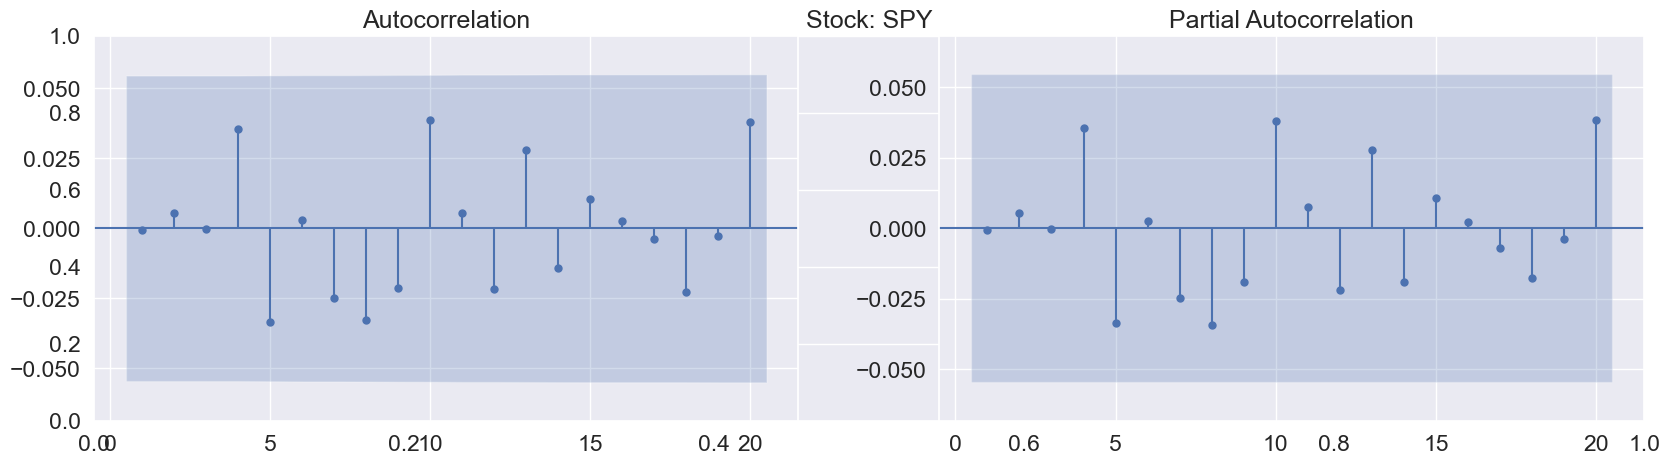

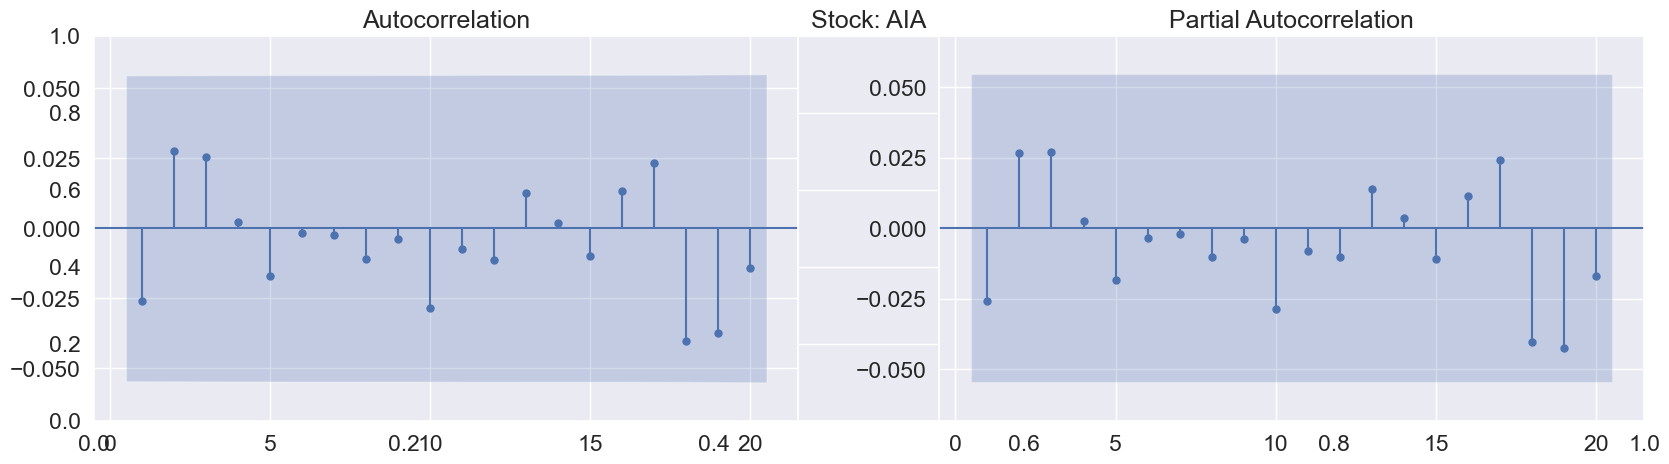

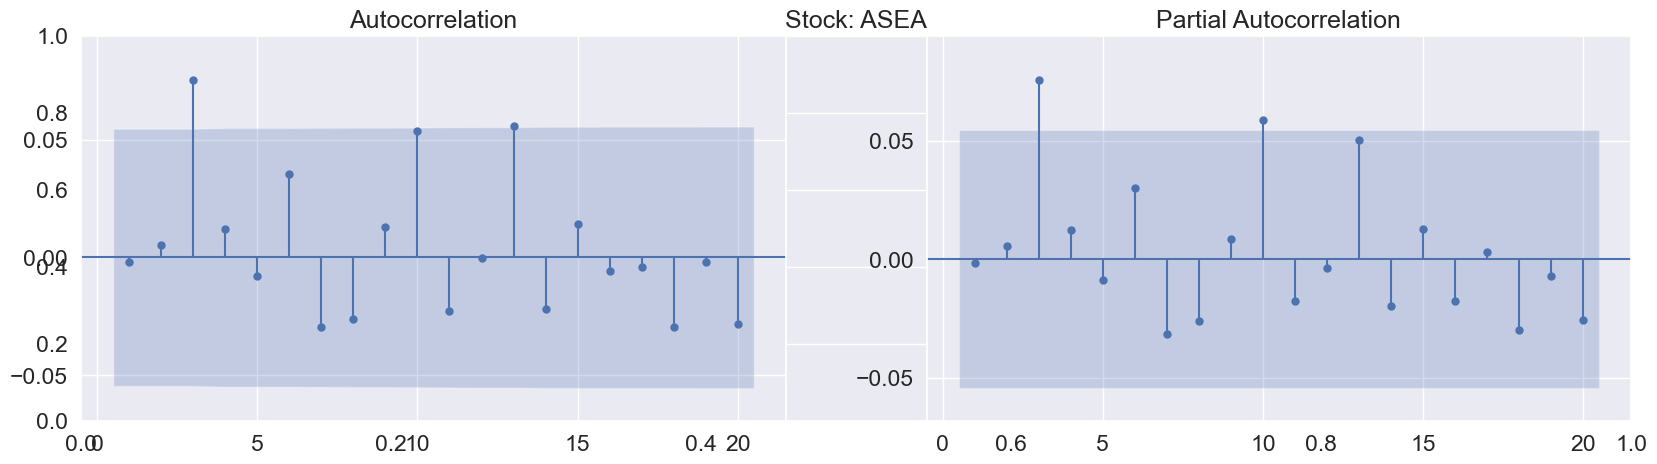

In [22]:
# plot ACF and PACF, zero lag is not plotted
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.set(font_scale=1.5)
    for stock_name in stock_list:
        standarized_resid = models[stock_name][1].resid/models[stock_name][1].conditional_volatility
        fig=plt.figure(figsize=(20,5))
        plot_name = 'Stock: ' + stock_name 
        plt.title(plot_name)
        axL=fig.add_subplot(121)
        acf_plot = sm.graphics.tsa.plot_acf(standarized_resid**2,lags=20,ax=axL, 
                                            zero=False, auto_ylims=True)
        axR=fig.add_subplot(122)
        pacf_plot = sm.graphics.tsa.plot_pacf(standarized_resid**2,lags=20,ax=axR, 
                                              zero=False, auto_ylims=True)
    sns.set(font_scale=2)

The ACF and PACF plots show that most of the dependences on lagged values have been succesfully modelled. There is arguably still a significant dependence on lag=3 for the ASEA stock. We can explore whether this dependence is significant using the Ljung-Box test.

The null hypothesis of the Ljung-Box test is that there is no correlation; done on the squared standarized residuals, a small p-value indicates that there might be leftover GARCH effects that are not modelled by our chosen GARCH processes. 

In [23]:
# Ljung-Box test on the squared standarized residual squared to show that no GARCH effects remain
for stock_name in stock_list:
    standarized_resid = models[stock_name][1].resid/models[stock_name][1].conditional_volatility

    # Ljung-Box test on the squared standarized residuals
    lb_st_res_sq = acorr_ljungbox(standarized_resid**2 , lags = 10)
    print('Ljung-Box test for the squared standarized residuals of stock: ' + stock_name)
    print(lb_st_res_sq)

Ljung-Box test for the squared standarized residuals of stock: SPY
     lb_stat  lb_pvalue
1   0.000625   0.980050
2   0.039371   0.980507
3   0.039514   0.997936
4   1.664720   0.797116
5   3.119274   0.681603
6   3.131270   0.792200
7   3.925675   0.788297
8   5.315810   0.723350
9   5.906354   0.749253
10  7.850678   0.643420
Ljung-Box test for the squared standarized residuals of stock: AIA
     lb_stat  lb_pvalue
1   0.862635   0.353002
2   1.838284   0.398861
3   2.673519   0.444746
4   2.679434   0.612818
5   3.048005   0.692585
6   3.051084   0.802409
7   3.059600   0.879434
8   3.213735   0.920237
9   3.231543   0.954403
10  4.280826   0.933790
Ljung-Box test for the squared standarized residuals of stock: ASEA
      lb_stat  lb_pvalue
1    0.004125   0.948792
2    0.041194   0.979614
3    7.369505   0.061008
4    7.554069   0.109349
5    7.634458   0.177565
6    9.260569   0.159445
7   10.402514   0.166887
8   11.300900   0.185226
9   11.512153   0.242229
10  15.279515   0.12

The Ljung-Box test show that up to lag=10, there is no significant p-value indicating leftover GARCH effects. As expected from the ACF and PACF plots on ASEA, there is a small p-value on lag=3. However, this p-value is not small enough to claim rejection of the null hypothesis at a significant confidence.

Next we will plot the histogram of the standarized residuals. The GARCH process we used to model the time series assumed normally distributed innovations. By checking whether the histogram is indeed normally distributed, we can confirm this assumption.

<Figure size 2000x500 with 0 Axes>

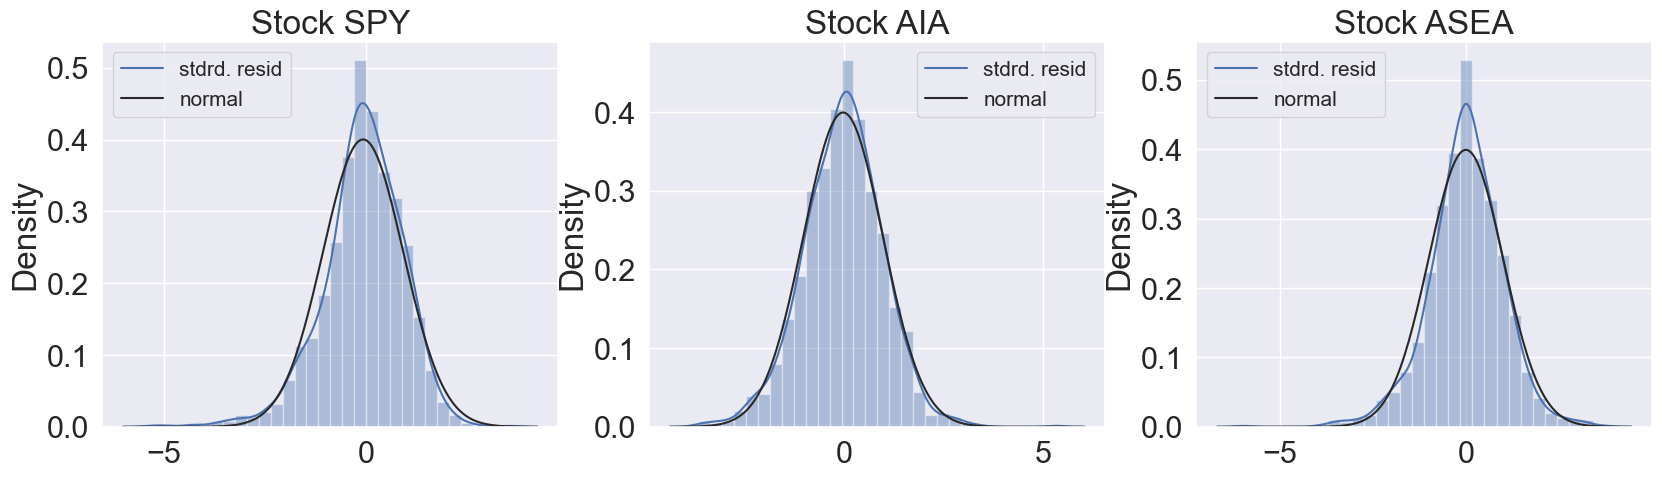

In [24]:
#Histogram of the standarized residuals for GARCH process with normally distributed innovations

fig=plt.figure(figsize=(20,5))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    fig=plt.figure(figsize=(20,5))
    for index, stock_name in enumerate(stock_list):
        standarized_resid = models[stock_name][1].resid/models[stock_name][1].conditional_volatility
        # Plot the histogram of the standardized residuals
        fig.add_subplot(1,3,index+1)
        plt.title('Stock '+ stock_name)
        
        sns.distplot(standarized_resid, norm_hist=True, fit=stats.norm, bins=30, color='b')
        plt.legend(('stdrd. resid','normal'), fontsize=15)
plt.savefig('residual_normal', bbox_inches='tight')

We see that the histograms deviate from the normal distribution. This indicates that the original assumption of normally distributed innovations is not appropriate. Looking at the histograms, we can see that the residual distributions overshoot the normal distribution near the mean, but are still quite symmetric. Given these observations, we will attempt another pass at modelling the time series, this time assuming Student-t distributed innovations. 

## Student-t distributed innovations

We can perform the same grid serach over the GARCH p and q parameters to find the model with the lowest AIC, now assuming Student-t distributed innovations

In [25]:
def find_garch_pq_stud(series, max_p=5, max_q=5):
    ''' Grid search for minimum AIC '''
    current_lowest=(0,0,np.inf)
    aic_list = []
    for i in range(1,max_p+1,1):
        for j in range(max_q+1):
            model = arch.arch_model(series, p=i, q=j, vol='GARCH',dist="StudentsT")
            res = model.fit()
            aic = res.aic
            if aic < current_lowest[2]:
                current_lowest = (i, j, aic)
            aic_list += [(i,j,aic)]
    return {'res':current_lowest, 'aic_list':aic_list}

In [26]:
pq_search_stud = {}
for stock_name in stock_list:
    pq_search_stud[stock_name] = find_garch_pq_stud(daily_returns[stock_name])

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8258.551167197487
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2898.760765447861
Iteration:      3,   Func. Count:     23,   Neg. LLF: 3297.145611125155
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3038.450371926271
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2014.766340314574
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2984.247084181684
Iteration:      7,   Func. Count:     47,   Neg. LLF: 2157.6822105521414
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1983.2999527430543
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1975.5132466776904
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1974.7933689437978
Iteration:     11,   Func. Count:     69,   Neg. LLF: 1974.6483601683885
Iteration:     12,   Func. Count:     74,   Neg. LLF: 1974.572870364495
Iteration:     13,   Func. Count:     79,   Neg. LLF: 1974.567116550193
Iteration:     14,   Func. Count:     84,   Neg. LLF: 1974.

Iteration:     13,   Func. Count:    134,   Neg. LLF: 1853.3747854332573
Iteration:     14,   Func. Count:    144,   Neg. LLF: 1853.1854968421167
Iteration:     15,   Func. Count:    154,   Neg. LLF: 1853.0750046737505
Iteration:     16,   Func. Count:    163,   Neg. LLF: 1853.0724642683253
Iteration:     17,   Func. Count:    172,   Neg. LLF: 1853.0699400349674
Iteration:     18,   Func. Count:    181,   Neg. LLF: 1853.0694300528708
Iteration:     19,   Func. Count:    190,   Neg. LLF: 1853.0691466468259
Iteration:     20,   Func. Count:    199,   Neg. LLF: 1853.0691248717012
Iteration:     21,   Func. Count:    208,   Neg. LLF: 1853.0691211676592
Iteration:     22,   Func. Count:    216,   Neg. LLF: 1853.0691211676594
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1853.0691211676592
            Iterations: 22
            Function evaluations: 216
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     11,   Neg. LLF: 8301.

Iteration:      1,   Func. Count:     12,   Neg. LLF: 8257.325466648024
Iteration:      2,   Func. Count:     28,   Neg. LLF: 3659.0732069072874
Iteration:      3,   Func. Count:     40,   Neg. LLF: 2013.7370851993014
Iteration:      4,   Func. Count:     52,   Neg. LLF: 2062.835817946261
Iteration:      5,   Func. Count:     64,   Neg. LLF: 1867.5160256937636
Iteration:      6,   Func. Count:     76,   Neg. LLF: 2408.8195441280714
Iteration:      7,   Func. Count:     89,   Neg. LLF: 1861.311464446279
Iteration:      8,   Func. Count:    101,   Neg. LLF: 1865.151950316441
Iteration:      9,   Func. Count:    113,   Neg. LLF: 1891.992633305252
Iteration:     10,   Func. Count:    125,   Neg. LLF: 1853.3603038719025
Iteration:     11,   Func. Count:    137,   Neg. LLF: 1853.2279835232382
Iteration:     12,   Func. Count:    149,   Neg. LLF: 1853.0292561295937
Iteration:     13,   Func. Count:    160,   Neg. LLF: 1853.389517157682
Iteration:     14,   Func. Count:    172,   Neg. LLF: 185

Iteration:     19,   Func. Count:    229,   Neg. LLF: 1853.069121302743
Iteration:     20,   Func. Count:    239,   Neg. LLF: 1853.0691213027458
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1853.069121302743
            Iterations: 20
            Function evaluations: 239
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     13,   Neg. LLF: 8220.011214609745
Iteration:      2,   Func. Count:     30,   Neg. LLF: 3640.785352053611
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1994.6441276171927
Iteration:      4,   Func. Count:     57,   Neg. LLF: 2072.5747695848995
Iteration:      5,   Func. Count:     70,   Neg. LLF: 2177.338804864915
Iteration:      6,   Func. Count:     83,   Neg. LLF: 1922.6713520847584
Iteration:      7,   Func. Count:     96,   Neg. LLF: 3116.3529744192365
Iteration:      8,   Func. Count:    109,   Neg. LLF: 1857.8702138874817
Iteration:      9,   Func. Count:    122,   Neg. LLF: 1856.75985

Iteration:      2,   Func. Count:     30,   Neg. LLF: 3659.292998902777
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1983.1980250794925
Iteration:      4,   Func. Count:     58,   Neg. LLF: 2372.4442531058644
Iteration:      5,   Func. Count:     71,   Neg. LLF: 2176.5875801085867
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1932.963321957071
Iteration:      7,   Func. Count:     98,   Neg. LLF: 3164.384380999131
Iteration:      8,   Func. Count:    111,   Neg. LLF: 1854.3989229166436
Iteration:      9,   Func. Count:    123,   Neg. LLF: 1853.6035313189414
Iteration:     10,   Func. Count:    135,   Neg. LLF: 1853.7888459245028
Iteration:     11,   Func. Count:    148,   Neg. LLF: 1853.276000008971
Iteration:     12,   Func. Count:    160,   Neg. LLF: 1853.2654848386535
Iteration:     13,   Func. Count:    172,   Neg. LLF: 1853.2651754777594
Iteration:     14,   Func. Count:    184,   Neg. LLF: 1853.2646955199702
Iteration:     15,   Func. Count:    196,   Neg. LLF: 1

Iteration:      7,   Func. Count:     64,   Neg. LLF: 2305.320781406437
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2303.3898669820214
Iteration:      9,   Func. Count:     82,   Neg. LLF: 2302.531331627647
Iteration:     10,   Func. Count:     91,   Neg. LLF: 2302.490457008811
Iteration:     11,   Func. Count:    100,   Neg. LLF: 2302.4466979827203
Iteration:     12,   Func. Count:    108,   Neg. LLF: 2302.446670547009
Iteration:     13,   Func. Count:    115,   Neg. LLF: 2302.4466705470063
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2302.446670547009
            Iterations: 13
            Function evaluations: 115
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     10,   Neg. LLF: 5753.6003594493795
Iteration:      2,   Func. Count:     22,   Neg. LLF: 2395.9270583023854
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2345.094910133922
Iteration:      4,   Func. Count:     42,   Neg. LLF: 2317.863737

Iteration:     11,   Func. Count:    134,   Neg. LLF: 2300.9466324224286
Iteration:     12,   Func. Count:    145,   Neg. LLF: 2300.958120842857
Iteration:     13,   Func. Count:    157,   Neg. LLF: 2300.933515006541
Iteration:     14,   Func. Count:    168,   Neg. LLF: 2300.9330971446097
Iteration:     15,   Func. Count:    179,   Neg. LLF: 2300.9330515626566
Iteration:     16,   Func. Count:    190,   Neg. LLF: 2300.933038770897
Iteration:     17,   Func. Count:    200,   Neg. LLF: 2300.933038770894
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2300.933038770897
            Iterations: 17
            Function evaluations: 200
            Gradient evaluations: 17
Iteration:      1,   Func. Count:      8,   Neg. LLF: 5129.394812852492
Iteration:      2,   Func. Count:     18,   Neg. LLF: 5244.4440454711585
Iteration:      3,   Func. Count:     28,   Neg. LLF: 3318.551069530029
Iteration:      4,   Func. Count:     36,   Neg. LLF: 2715.6860846

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4742.936444186887
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5592.350217378111
Iteration:      3,   Func. Count:     31,   Neg. LLF: 2929.610601992175
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2792.2912171401695
Iteration:      5,   Func. Count:     49,   Neg. LLF: 3724.901365609465
Iteration:      6,   Func. Count:     58,   Neg. LLF: 2333.3962395462654
Iteration:      7,   Func. Count:     67,   Neg. LLF: 3276.95303101867
Iteration:      8,   Func. Count:     76,   Neg. LLF: 3396.530236648534
Iteration:      9,   Func. Count:     85,   Neg. LLF: 2310.6286214880824
Iteration:     10,   Func. Count:     94,   Neg. LLF: 2309.847941226365
Iteration:     11,   Func. Count:    102,   Neg. LLF: 2309.7933842806774
Iteration:     12,   Func. Count:    110,   Neg. LLF: 2309.7685029787426
Iteration:     13,   Func. Count:    118,   Neg. LLF: 2309.767222486037
Iteration:     14,   Func. Count:    126,   Neg. LLF: 2309.7

Iteration:      1,   Func. Count:     10,   Neg. LLF: 4488.139353623767
Iteration:      2,   Func. Count:     22,   Neg. LLF: 5817.616711527937
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4506.7175344802445
Iteration:      4,   Func. Count:     44,   Neg. LLF: 4367.028071400033
Iteration:      5,   Func. Count:     54,   Neg. LLF: 2887.823071553967
Iteration:      6,   Func. Count:     64,   Neg. LLF: 3652.5585315654835
Iteration:      7,   Func. Count:     74,   Neg. LLF: 2327.25134683144
Iteration:      8,   Func. Count:     84,   Neg. LLF: 2500.9696038321063
Iteration:      9,   Func. Count:     95,   Neg. LLF: 2569.5674572143653
Iteration:     10,   Func. Count:    105,   Neg. LLF: 2313.621495664267
Iteration:     11,   Func. Count:    115,   Neg. LLF: 2310.830501170414
Iteration:     12,   Func. Count:    125,   Neg. LLF: 2309.3427570204435
Iteration:     13,   Func. Count:    134,   Neg. LLF: 2309.263284358638
Iteration:     14,   Func. Count:    143,   Neg. LLF: 2309.2

Iteration:      1,   Func. Count:     15,   Neg. LLF: 5218.109617250057
Iteration:      2,   Func. Count:     32,   Neg. LLF: 4593.7220392382915
Iteration:      3,   Func. Count:     47,   Neg. LLF: 2435.352365896365
Iteration:      4,   Func. Count:     63,   Neg. LLF: 2461.8245507605197
Iteration:      5,   Func. Count:     78,   Neg. LLF: 2358.639036056068
Iteration:      6,   Func. Count:     93,   Neg. LLF: 2325.7711794720067
Iteration:      7,   Func. Count:    108,   Neg. LLF: 2368.0993384170483
Iteration:      8,   Func. Count:    123,   Neg. LLF: 2330.248042133562
Iteration:      9,   Func. Count:    138,   Neg. LLF: 2334.641720919147
Iteration:     10,   Func. Count:    153,   Neg. LLF: 2301.0363106520604
Iteration:     11,   Func. Count:    167,   Neg. LLF: 2304.3720854091234
Iteration:     12,   Func. Count:    182,   Neg. LLF: 2311.4681630743107
Iteration:     13,   Func. Count:    197,   Neg. LLF: 2300.327978302068
Iteration:     14,   Func. Count:    211,   Neg. LLF: 230

Iteration:      3,   Func. Count:     29,   Neg. LLF: 2064.8563509358446
Iteration:      4,   Func. Count:     39,   Neg. LLF: 2054.1200051213204
Iteration:      5,   Func. Count:     48,   Neg. LLF: 3025.8105189061116
Iteration:      6,   Func. Count:     56,   Neg. LLF: 1876.9573778057495
Iteration:      7,   Func. Count:     63,   Neg. LLF: 1877.218394039944
Iteration:      8,   Func. Count:     71,   Neg. LLF: 1876.9362136780414
Iteration:      9,   Func. Count:     79,   Neg. LLF: 1876.8786326134573
Iteration:     10,   Func. Count:     86,   Neg. LLF: 1876.8786276274036
Iteration:     11,   Func. Count:     92,   Neg. LLF: 1876.8786276273995
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1876.8786276274036
            Iterations: 11
            Function evaluations: 92
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      9,   Neg. LLF: 68944.32538777142
Iteration:      2,   Func. Count:     20,   Neg. LLF: 37687.51

Iteration:      1,   Func. Count:     11,   Neg. LLF: 57534.831892318005
Iteration:      2,   Func. Count:     24,   Neg. LLF: 34585.37136955738
Iteration:      3,   Func. Count:     36,   Neg. LLF: 3383.4547282068806
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3204.5336286867823
Iteration:      5,   Func. Count:     59,   Neg. LLF: 1997.5711436102633
Iteration:      6,   Func. Count:     70,   Neg. LLF: 1889.757528186733
Iteration:      7,   Func. Count:     81,   Neg. LLF: 2903.9103299498784
Iteration:      8,   Func. Count:     92,   Neg. LLF: 1911.968492528369
Iteration:      9,   Func. Count:    104,   Neg. LLF: 1876.232097977825
Iteration:     10,   Func. Count:    114,   Neg. LLF: 1875.6345600099207
Iteration:     11,   Func. Count:    124,   Neg. LLF: 1882.6083455466596
Iteration:     12,   Func. Count:    136,   Neg. LLF: 1875.5330775374819
Iteration:     13,   Func. Count:    146,   Neg. LLF: 1875.5285644819658
Iteration:     14,   Func. Count:    156,   Neg. LLF: 1

Iteration:      7,   Func. Count:     88,   Neg. LLF: 1904.7203719090041
Iteration:      8,   Func. Count:    100,   Neg. LLF: 1904.214631832654
Iteration:      9,   Func. Count:    112,   Neg. LLF: 1877.3027039059632
Iteration:     10,   Func. Count:    124,   Neg. LLF: 1888.394691446159
Iteration:     11,   Func. Count:    136,   Neg. LLF: 1876.4793622903403
Iteration:     12,   Func. Count:    147,   Neg. LLF: 1876.446035956781
Iteration:     13,   Func. Count:    158,   Neg. LLF: 1876.4053134288788
Iteration:     14,   Func. Count:    169,   Neg. LLF: 1876.403327160692
Iteration:     15,   Func. Count:    181,   Neg. LLF: 1876.391340902865
Iteration:     16,   Func. Count:    192,   Neg. LLF: 1876.3912312405469
Iteration:     17,   Func. Count:    203,   Neg. LLF: 1876.3912171977172
Iteration:     18,   Func. Count:    214,   Neg. LLF: 1876.3912140705984
Iteration:     19,   Func. Count:    224,   Neg. LLF: 1876.391214070598
Optimization terminated successfully    (Exit mode 0)
   

Iteration:     13,   Func. Count:    159,   Neg. LLF: 1876.765725879415
Iteration:     14,   Func. Count:    170,   Neg. LLF: 1876.736714900123
Iteration:     15,   Func. Count:    181,   Neg. LLF: 1876.7352947529512
Iteration:     16,   Func. Count:    192,   Neg. LLF: 1876.7350706739799
Iteration:     17,   Func. Count:    203,   Neg. LLF: 1876.7350098285483
Iteration:     18,   Func. Count:    214,   Neg. LLF: 1876.7350020955791
Iteration:     19,   Func. Count:    224,   Neg. LLF: 1876.7350020955762
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1876.7350020955791
            Iterations: 19
            Function evaluations: 224
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     13,   Neg. LLF: 53162.14248458271
Iteration:      2,   Func. Count:     28,   Neg. LLF: 31600.118752192786
Iteration:      3,   Func. Count:     42,   Neg. LLF: 3441.9728532108866
Iteration:      4,   Func. Count:     55,   Neg. LLF: 3139.221

Let us print out the result of the grid search to see the best GARCH models for each stocks:

In [27]:
for stock_name in stock_list:
    print('Result of grid search for GARCH with Student-t innovation order for stock ' + stock_name + ' is:')
    print(pq_search_stud[stock_name]['res'])

Result of grid search for GARCH with Student-t innovation order for stock SPY is:
(1, 1, 3717.6847314246447)
Result of grid search for GARCH with Student-t innovation order for stock AIA is:
(1, 1, 4614.893340363285)
Result of grid search for GARCH with Student-t innovation order for stock ASEA is:
(1, 1, 3763.7572547399304)


Despite the additional degree of freedom, all of the AICs improved from the normal distribution version! We will keep these models as our candidate models.

In [28]:
pq_list_stud = {'SPY': (1,1), 'AIA':(1,1), 'ASEA':(1,1)}

In [29]:
models_stud = {}
for stock_name in stock_list:
    print('Now doing analysis for stock: ' + stock_name)
    model = arch.arch_model(daily_returns[stock_name], p = pq_list_stud[stock_name][0], q = pq_list_stud[stock_name][1], vol = 'GARCH', dist="StudentsT")
    res = model.fit()
    models_stud[stock_name] = [model,res]

Now doing analysis for stock: SPY
Iteration:      1,   Func. Count:      7,   Neg. LLF: 9777.58613788899
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3749.6177986046287
Iteration:      3,   Func. Count:     26,   Neg. LLF: 1873.3414316050712
Iteration:      4,   Func. Count:     33,   Neg. LLF: 4159.99565701401
Iteration:      5,   Func. Count:     41,   Neg. LLF: 1863.0497309201978
Iteration:      6,   Func. Count:     48,   Neg. LLF: 1853.8950678660722
Iteration:      7,   Func. Count:     54,   Neg. LLF: 2357.6578376610214
Iteration:      8,   Func. Count:     62,   Neg. LLF: 1863.5077039135017
Iteration:      9,   Func. Count:     70,   Neg. LLF: 1853.84248893065
Iteration:     10,   Func. Count:     76,   Neg. LLF: 1853.8423657123224
Iteration:     11,   Func. Count:     81,   Neg. LLF: 1853.8423657123187
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1853.8423657123224
            Iterations: 11
            Function evaluations:

In [30]:
models_stud['ASEA'][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         ASEA   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1876.88
Distribution:      Standardized Student's t   AIC:                           3763.76
Method:                  Maximum Likelihood   BIC:                           3789.57
                                              No. Observations:                 1291
Date:                      Sun, Mar 26 2023   Df Residuals:                     1290
Time:                              20:49:43   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0169  2.567e-02      0.658      0.511 [-3.344e-02,6.720e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0491  2.570e-02      1.911  5.597e-02 [-1.251e-03,9.950e-02]
alpha[1]       0.0823  2.645e-02      3.111  1.861e-03    [3.045e-02,  0.134]
beta[1]        0.8797  4.088e-02     21.520 1.007e-102      [  0.800,  0.960]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.7950      0.888      6.527  6.723e-11 [  4.055,  7.535]
========================================================================

Covariance estimator: robust
"""

We can overplot the modelled volatilities over the daily returns:

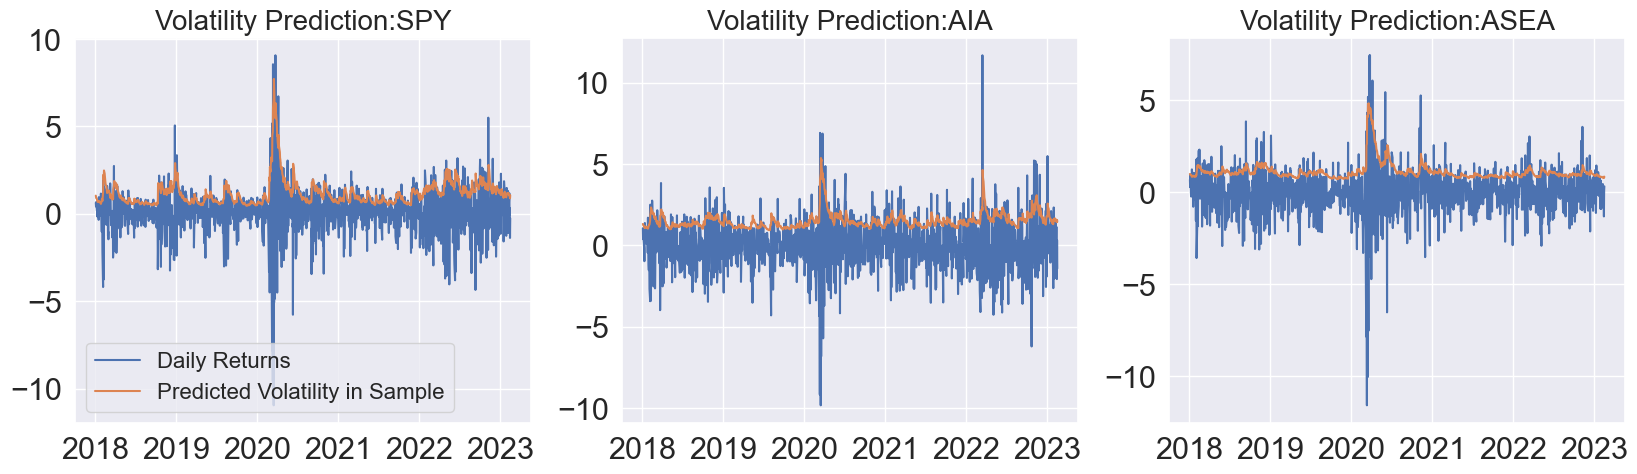

In [31]:
fig=plt.figure(figsize=(20,5))
for index, stock_name in enumerate(stock_list):
    fig.add_subplot(1,3,index+1)
    vol_model = models_stud[stock_name][1].conditional_volatility
    daily_returns_plot = plt.plot(daily_returns[stock_name])
    vol_model_plot = plt.plot(vol_model)
    plt.title('Volatility Prediction:' + stock_name, fontsize=20)
    if stock_name == 'SPY':
        plt.legend(['Daily Returns', 'Predicted Volatility in Sample'], fontsize=16)

### Student-t distributed innovations: residual diagnostics

Once again, to make sure that our assumptions are appropriate, we will analyze the standarized residuals.

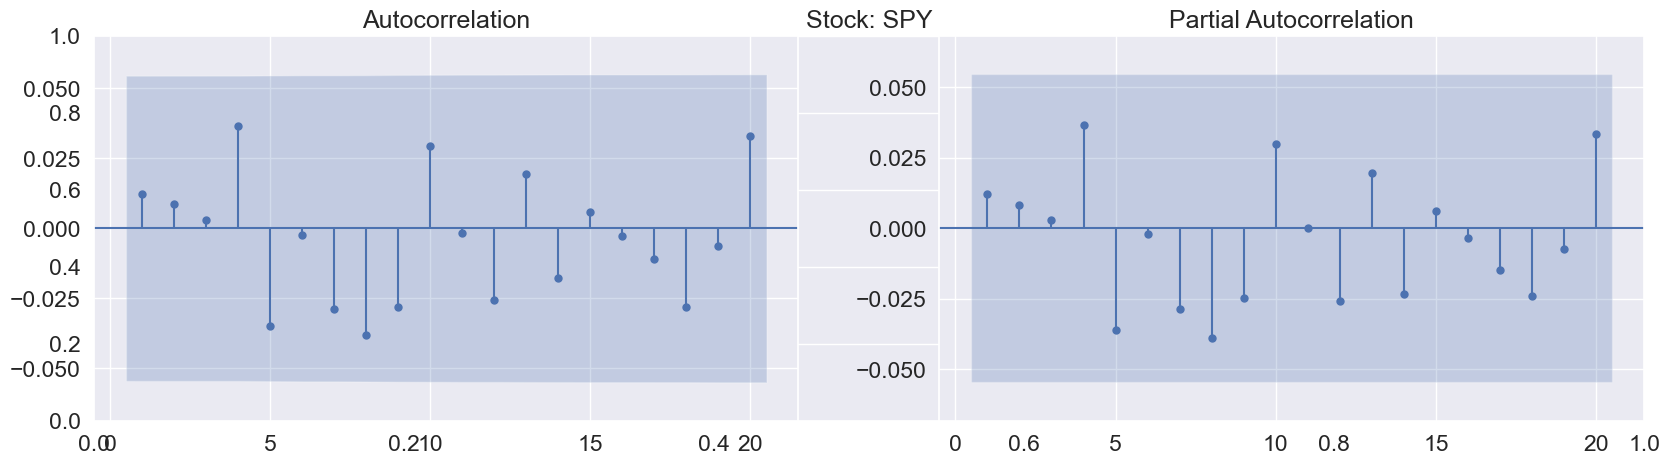

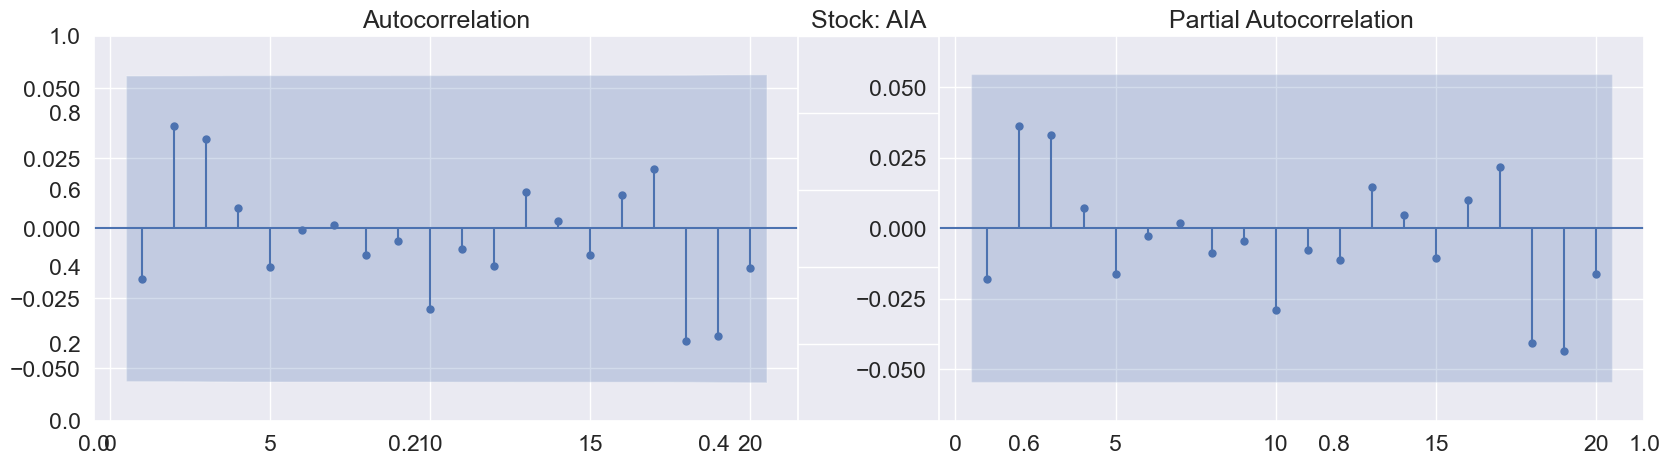

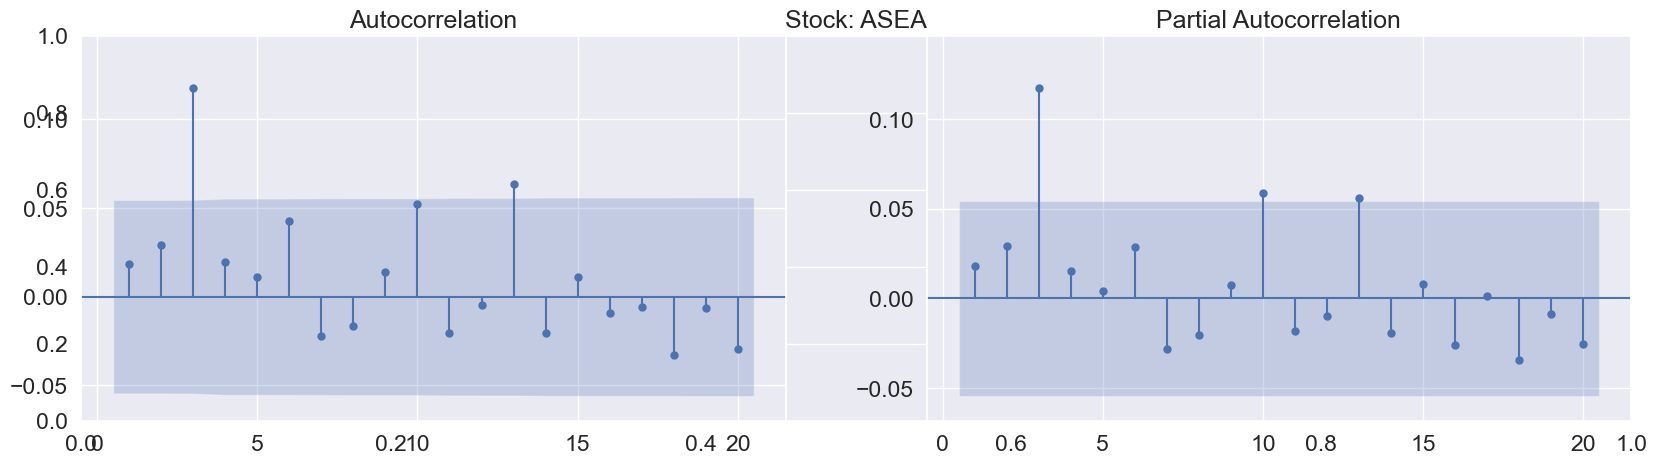

In [32]:
# plot ACF and PACF, zero lag is not plotted
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.set(font_scale=1.5)
    for stock_name in stock_list:
        standarized_resid = models_stud[stock_name][1].resid/models_stud[stock_name][1].conditional_volatility
        fig=plt.figure(figsize=(20,5))
        plot_name = 'Stock: ' + stock_name 
        plt.title(plot_name)
        axL=fig.add_subplot(121)
        acf_plot = sm.graphics.tsa.plot_acf(standarized_resid**2,lags=20,ax=axL, 
                                            zero=False, auto_ylims=True)
        axR=fig.add_subplot(122)
        pacf_plot = sm.graphics.tsa.plot_pacf(standarized_resid**2,lags=20,ax=axR, 
                                              zero=False, auto_ylims=True)
    sns.set(font_scale=2)

With the Student-t's distributed innovations, we can see that the ACF and PACF of the ASEA ETF still show significant dependencies on lag=3.

In [33]:
# Ljung-Box test on the standarized residual squared to show that no GARCH effects remain
for stock_name in stock_list:
    standarized_resid = models_stud[stock_name][1].resid/models_stud[stock_name][1].conditional_volatility

    # Ljung-Box test on the standarized residuals squared
    lb_st_res_sq = acorr_ljungbox(standarized_resid**2 , lags = 10)
    print('Ljung-Box test for the standarized residuals squared of stock: ' + stock_name)
    print(lb_st_res_sq)

Ljung-Box test for the standarized residuals squared of stock: SPY
     lb_stat  lb_pvalue
1   0.189675   0.663188
2   0.284417   0.867440
3   0.296153   0.960750
4   2.036459   0.729053
5   3.630028   0.603810
6   3.637115   0.725647
7   4.707805   0.695571
8   6.582482   0.582274
9   7.624129   0.572423
10  8.738156   0.557121
Ljung-Box test for the standarized residuals squared of stock: AIA
     lb_stat  lb_pvalue
1   0.422863   0.515512
2   2.161088   0.339411
3   3.470337   0.324630
4   3.540381   0.471765
5   3.787962   0.580330
6   3.788613   0.705257
7   3.790641   0.803551
8   3.911753   0.864996
9   3.937647   0.915468
10  5.021149   0.889761
Ljung-Box test for the standarized residuals squared of stock: ASEA
      lb_stat  lb_pvalue
1    0.431496   0.511256
2    1.544586   0.461953
3   19.516176   0.000214
4   20.026082   0.000494
5   20.181063   0.001156
6   22.563806   0.000957
7   23.201750   0.001572
8   23.567043   0.002708
9   23.816707   0.004601
10  27.357131   0.00

From the ACF and PACF plots as well as the Ljung-Box test, we can see that there is some leftover GARCH effects on ASEA. Particularly, it looks like the lag=3 dependencies is quite strong. 

To model this leftover effect, let us replace the GARCH model for the ASEA ETF to ARCH(3). From the grid search, we know that the AIC increase is not very large by swapping to this model. Not shown in this notebook, but we have also confirmed that ARCH(3) also overperformed GARCH(3,3) for this time series.

In [34]:
pq_list_stud = {'SPY': (1,1), 'AIA':(1,1), 'ASEA':(3,0)}

In [35]:
model = arch.arch_model(daily_returns['ASEA'], p = pq_list_stud['ASEA'][0], 
                        q = pq_list_stud['ASEA'][1], vol = 'GARCH', dist="StudentsT")
res = model.fit()
models_stud['ASEA'] = [model,res]
models_stud['ASEA'][1].summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 6423.607495538263
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3426.7831017962635
Iteration:      3,   Func. Count:     28,   Neg. LLF: 2177.594166028774
Iteration:      4,   Func. Count:     36,   Neg. LLF: 2304.731307042708
Iteration:      5,   Func. Count:     44,   Neg. LLF: 2249.4206245085493
Iteration:      6,   Func. Count:     52,   Neg. LLF: 1900.7303476403097
Iteration:      7,   Func. Count:     61,   Neg. LLF: 1905.2517026159162
Iteration:      8,   Func. Count:     69,   Neg. LLF: 1895.8712194623477
Iteration:      9,   Func. Count:     76,   Neg. LLF: 1895.8657550035573
Iteration:     10,   Func. Count:     83,   Neg. LLF: 1895.8656638571833
Iteration:     11,   Func. Count:     90,   Neg. LLF: 1895.8656576883084
Iteration:     12,   Func. Count:     97,   Neg. LLF: 1895.8656568317474
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1895.8656568317474
            Iterat

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - ARCH Model Results                         
====================================================================================
Dep. Variable:                         ASEA   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -1895.87
Distribution:      Standardized Student's t   AIC:                           3803.73
Method:                  Maximum Likelihood   BIC:                           3834.71
                                              No. Observations:                 1291
Date:                      Sun, Mar 26 2023   Df Residuals:                     1290
Time:                              20:49:44   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0181  2.620e-02      0.690      0.490 [-3.326e-02,6.943e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.7920  7.253e-02     10.919  9.342e-28   [  0.650,  0.934]
alpha[1]       0.1429  4.195e-02      3.406  6.592e-04 [6.066e-02,  0.225]
alpha[2]       0.1268  4.776e-02      2.655  7.941e-03 [3.317e-02,  0.220]
alpha[3]       0.1379  4.760e-02      2.897  3.772e-03 [4.458e-02,  0.231]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.0275      0.705      7.132  9.891e-13 [  3.646,  6.409]
========================================================================

Covariance estimator: robust
"""

As seen from the p-values, the lag=3 parameters are significant, justifying our new choice of order parameter.

Let us plot the ACF and PACF for the ASEA stock with this new model:

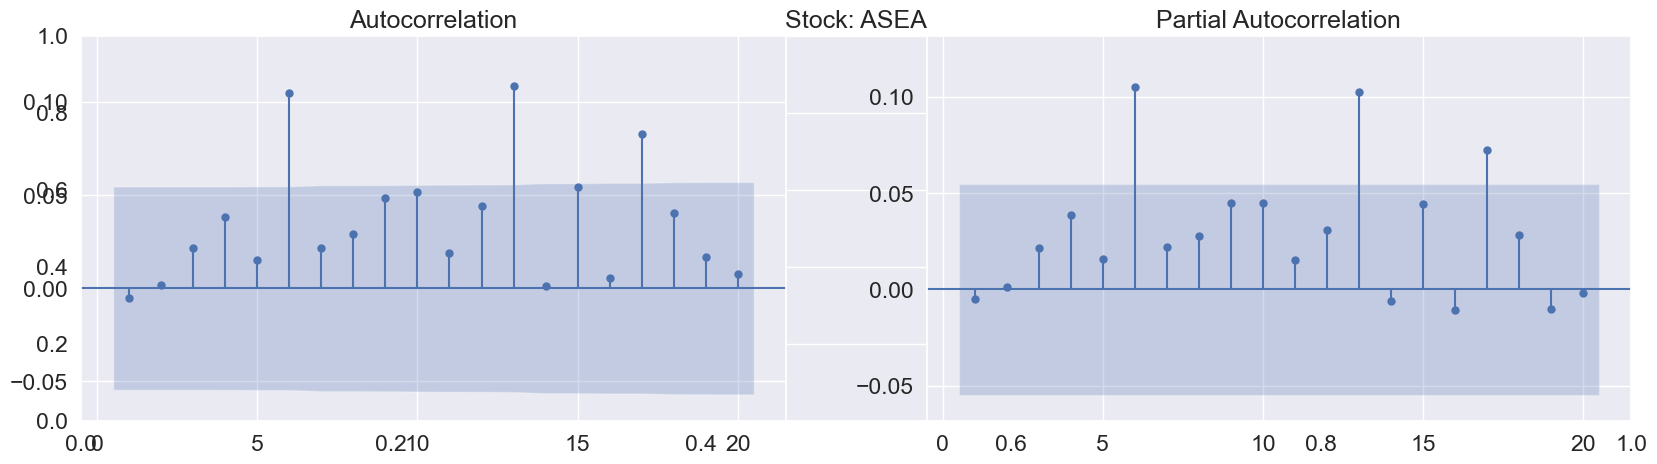

In [36]:
# plot ACF and PACF, zero lag is not plotted
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.set(font_scale=1.5)
    standarized_resid = models_stud['ASEA'][1].resid/models_stud['ASEA'][1].conditional_volatility
    fig=plt.figure(figsize=(20,5))
    plot_name = 'Stock: ' + 'ASEA' 
    plt.title(plot_name)
    axL=fig.add_subplot(121)
    acf_plot = sm.graphics.tsa.plot_acf(standarized_resid**2,lags=20,ax=axL, 
                                        zero=False, auto_ylims=True)
    axR=fig.add_subplot(122)
    pacf_plot = sm.graphics.tsa.plot_pacf(standarized_resid**2,lags=20,ax=axR, 
                                          zero=False, auto_ylims=True)
    sns.set(font_scale=2)

From the ACF and PACF plots, the slightly significant lags lefts are large. Curiously, the leftover lags are 6 and 12, which might indicate some sort of seasonal effects. We will not model these at the moment and leave its exploration for the future.

In [37]:
# Ljung-Box test on the standarized residual squared to show that no GARCH effects remain

standarized_resid = models_stud['ASEA'][1].resid/models_stud['ASEA'][1].conditional_volatility
# Ljung-Box test on the standarized residuals squared
lb_st_res_sq = acorr_ljungbox(standarized_resid**2 , lags = 12)
print('Ljung-Box test for the standarized residuals squared of stock: ' + 'ASEA')
print(lb_st_res_sq)

Ljung-Box test for the standarized residuals squared of stock: ASEA
      lb_stat  lb_pvalue
1    0.034654   0.852322
2    0.037515   0.981417
3    0.633006   0.888837
4    2.551429   0.635451
5    2.854777   0.722363
6   17.178919   0.008648
7   17.793345   0.012938
8   18.879601   0.015517
9   21.955300   0.009022
10  25.434045   0.004581
11  25.901269   0.006713
12  28.451143   0.004750


Similar to the ACF/PACF plots, we see that the dependence on lag=3 has been modelled out. There are still some significant lags, but as these are large lags we will not model them to keep our model parsimonious. 

Let us look at the standarized residual histograms now:

<Figure size 2000x500 with 0 Axes>

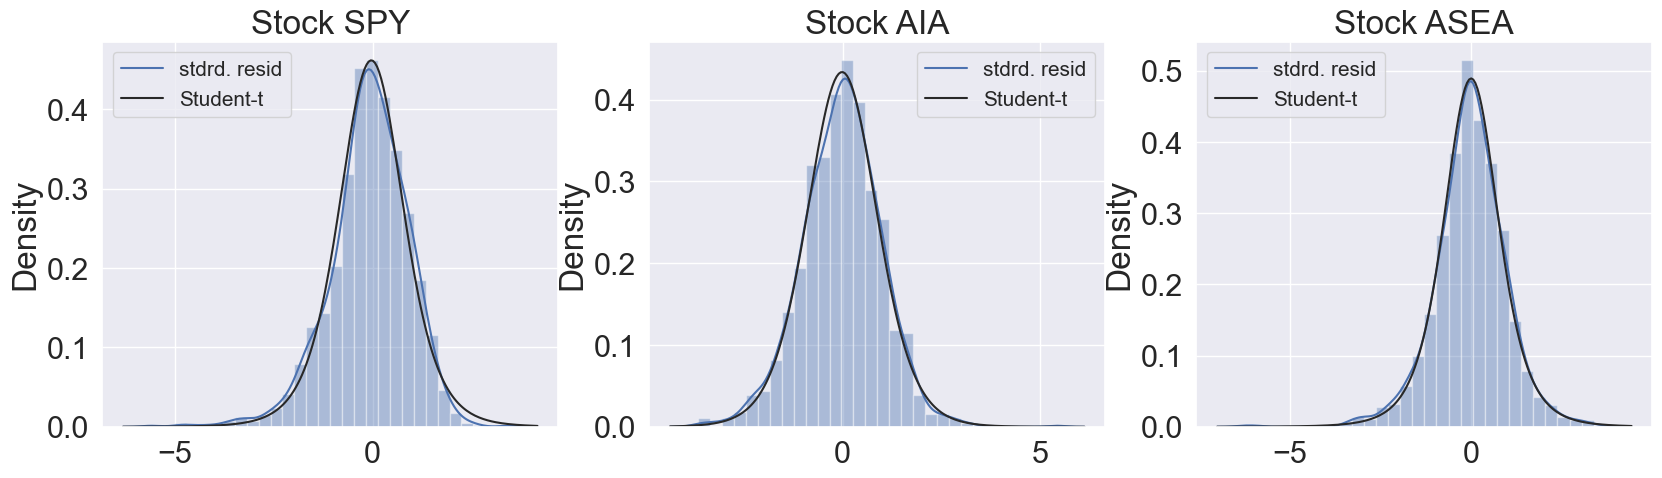

In [38]:
#Histogram of the standarized residuals for GARCH process with Student distributed innovations

fig=plt.figure(figsize=(20,5))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    fig=plt.figure(figsize=(20,5))
    for index, stock_name in enumerate(stock_list):
        standarized_resid = models_stud[stock_name][1].resid/models_stud[stock_name][1].conditional_volatility
        # Plot the histogram of the standardized residuals
        fig.add_subplot(1,3,index+1)
        plt.title('Stock '+ stock_name)
        sns.distplot(standarized_resid, norm_hist=True, fit=stats.t, bins=30, color='b')
        plt.legend(('stdrd. resid','Student-t'), fontsize=15)
    
plt.savefig('residual_student-t', bbox_inches='tight')

The standarized residuals histograms are well modelled by the Student-t distribution, meaning that our assumption that the innovations are Student-t distributed was a good one.

Let us overplot the modelled volatility over the daily returns:

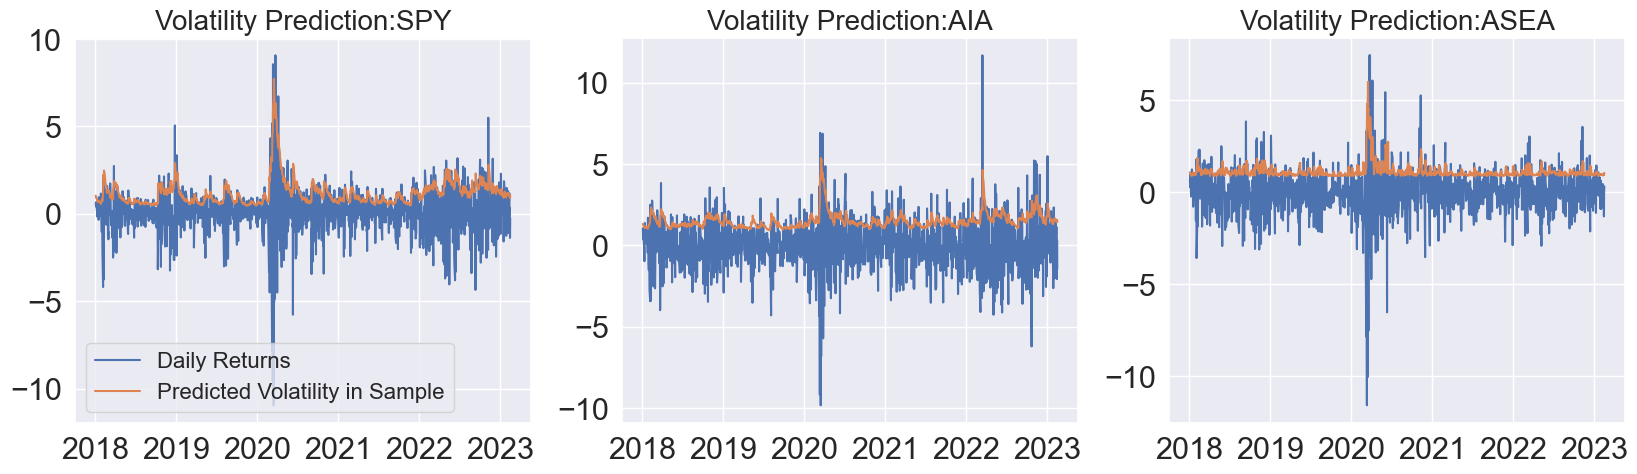

In [39]:
fig=plt.figure(figsize=(20,5))
for index, stock_name in enumerate(stock_list):
    fig.add_subplot(1,3,index+1)
    vol_model = models_stud[stock_name][1].conditional_volatility
    daily_returns_plot = plt.plot(daily_returns[stock_name])
    vol_model_plot = plt.plot(vol_model)
    plt.title('Volatility Prediction:' + stock_name, fontsize=20)
    if stock_name == 'SPY':
        plt.legend(['Daily Returns', 'Predicted Volatility in Sample'], fontsize=16)

# Results 

## Final models

Our final models are (all with Student-t distributed errors):
-  SPY: GARCH(1,1)
-  AIA: GARCH(1,1)
-  ASEA: ARCH(3,0)

## Rolling predictions

In a rolling prediction, we assume that we start at day 0 (at the beginning of the dataset) and see each datapoint sequentially one by one. After every new datapoint, the model for each ETF is updated with the true value of the time series and generate a prediction for the next point. This simulates the situation in real life, where we get to see the datapoints one day at a time. 

Let's see how our chosen GARCH(p,q) models model the volatilities in a rolling basis.

In [40]:
test_size = len(daily_returns)-2
def rolling_predictions(time_series, p, q, test_size=test_size, mod='Normal'):
    predictions = []

    for i in range(test_size):
        train = time_series.iloc[:-(test_size-i)]
        if mod == 'Normal':
            model = arch.arch_model(train, p=p, q=q, vol='GARCH')
        elif mod == 'StudentsT':
            model = arch.arch_model(train, p=p, q=q, vol='GARCH', dist='StudentsT')
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
        
    return predictions

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    predictions_SPY = rolling_predictions(daily_returns['SPY'],1,1, mod='StudentsT')
    predictions_AIA = rolling_predictions(daily_returns['AIA'],1,1, mod='StudentsT')
    predictions_ASEA = rolling_predictions(daily_returns['ASEA'],3,0, mod='StudentsT')
    predictions_all = {'SPY':predictions_SPY,'AIA':predictions_AIA,'ASEA':predictions_ASEA}

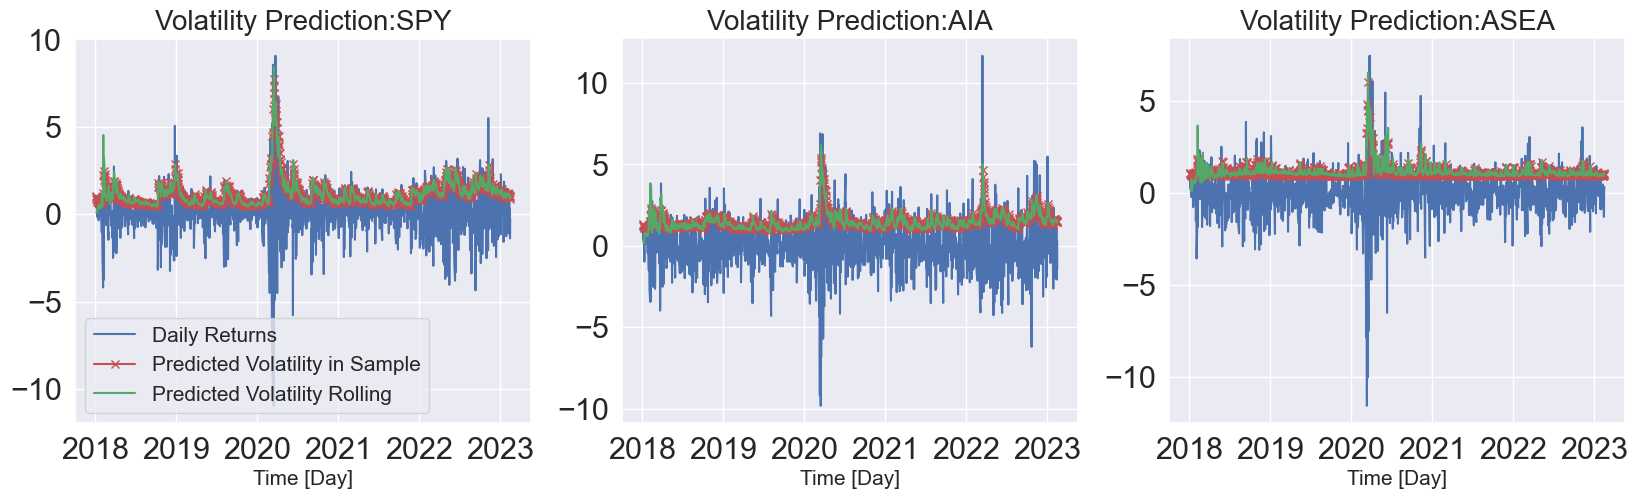

In [42]:
test_size = len(daily_returns)-2
fig=plt.figure(figsize=(20,5))

for index, stock_name in enumerate(stock_list):    
    fig_num = int('13' + str(index + 1))
    fig.add_subplot(fig_num)
    
    # daily returns plot
    daily_returns_plot = plt.plot(daily_returns[stock_name],color='b')
    
    # in sample predictions plot
    vol_model = models_stud[stock_name][1].conditional_volatility  
    vol_model_plot = plt.plot(vol_model,color='r', marker='x')
    
    # rolling predictions plot
    roll_preds = pd.Series(predictions_all[stock_name], index=daily_returns.index[-test_size:])
    roll_preds_plot = plt.plot(roll_preds, color='g')
    plt.title('Volatility Prediction:' + stock_name, fontsize=20)
    
    plt.xlabel('Time [Day]',fontsize=15)    
    if stock_name == 'SPY':
        plt.legend(['Daily Returns', 'Predicted Volatility in Sample','Predicted Volatility Rolling'], fontsize=15)
filename = 'vol_pred_roll'#+'.pdf'
plt.savefig(filename, bbox_inches='tight')

Both in-sample and rolling predictions show that when the ETF prices rise/fall sharply, the volatilities spike, which is what we expected!

## Forecasts

Finally, we will produce a forecast of the volatilities for the 21 days (1 month) after the end of the dataset.

In [43]:
# This chunk of code is modified from a sample from the arch documentation:
# https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html

def forecast_next_month(stock_name, plot=True):
    ''' Returns the sqrt of the variances '''
    forecast_horizon=21
    forecasts = models_stud[stock_name][1].forecast(horizon=forecast_horizon, method="simulation", reindex=False, random_state=1)
    sims = forecasts.simulations
    x = np.arange(1, forecast_horizon+1)
    if plot:
        lines = plt.plot(x, np.sqrt(sims.residual_variances[-1, ::forecast_horizon]).T, color="#9cb2d6", alpha=0.5)
        lines[0].set_label("Simulated path")
        line = plt.plot(x, np.sqrt(forecasts.variance.iloc[-1].values), color="#002868")
        line[0].set_label("Sqrt expected variance - sims")
        plt.gca().set_xticks(x)
        plt.gca().set_xlim(1, forecast_horizon+1)
        legend = plt.legend()
    return np.sqrt(sims.variances[-1])

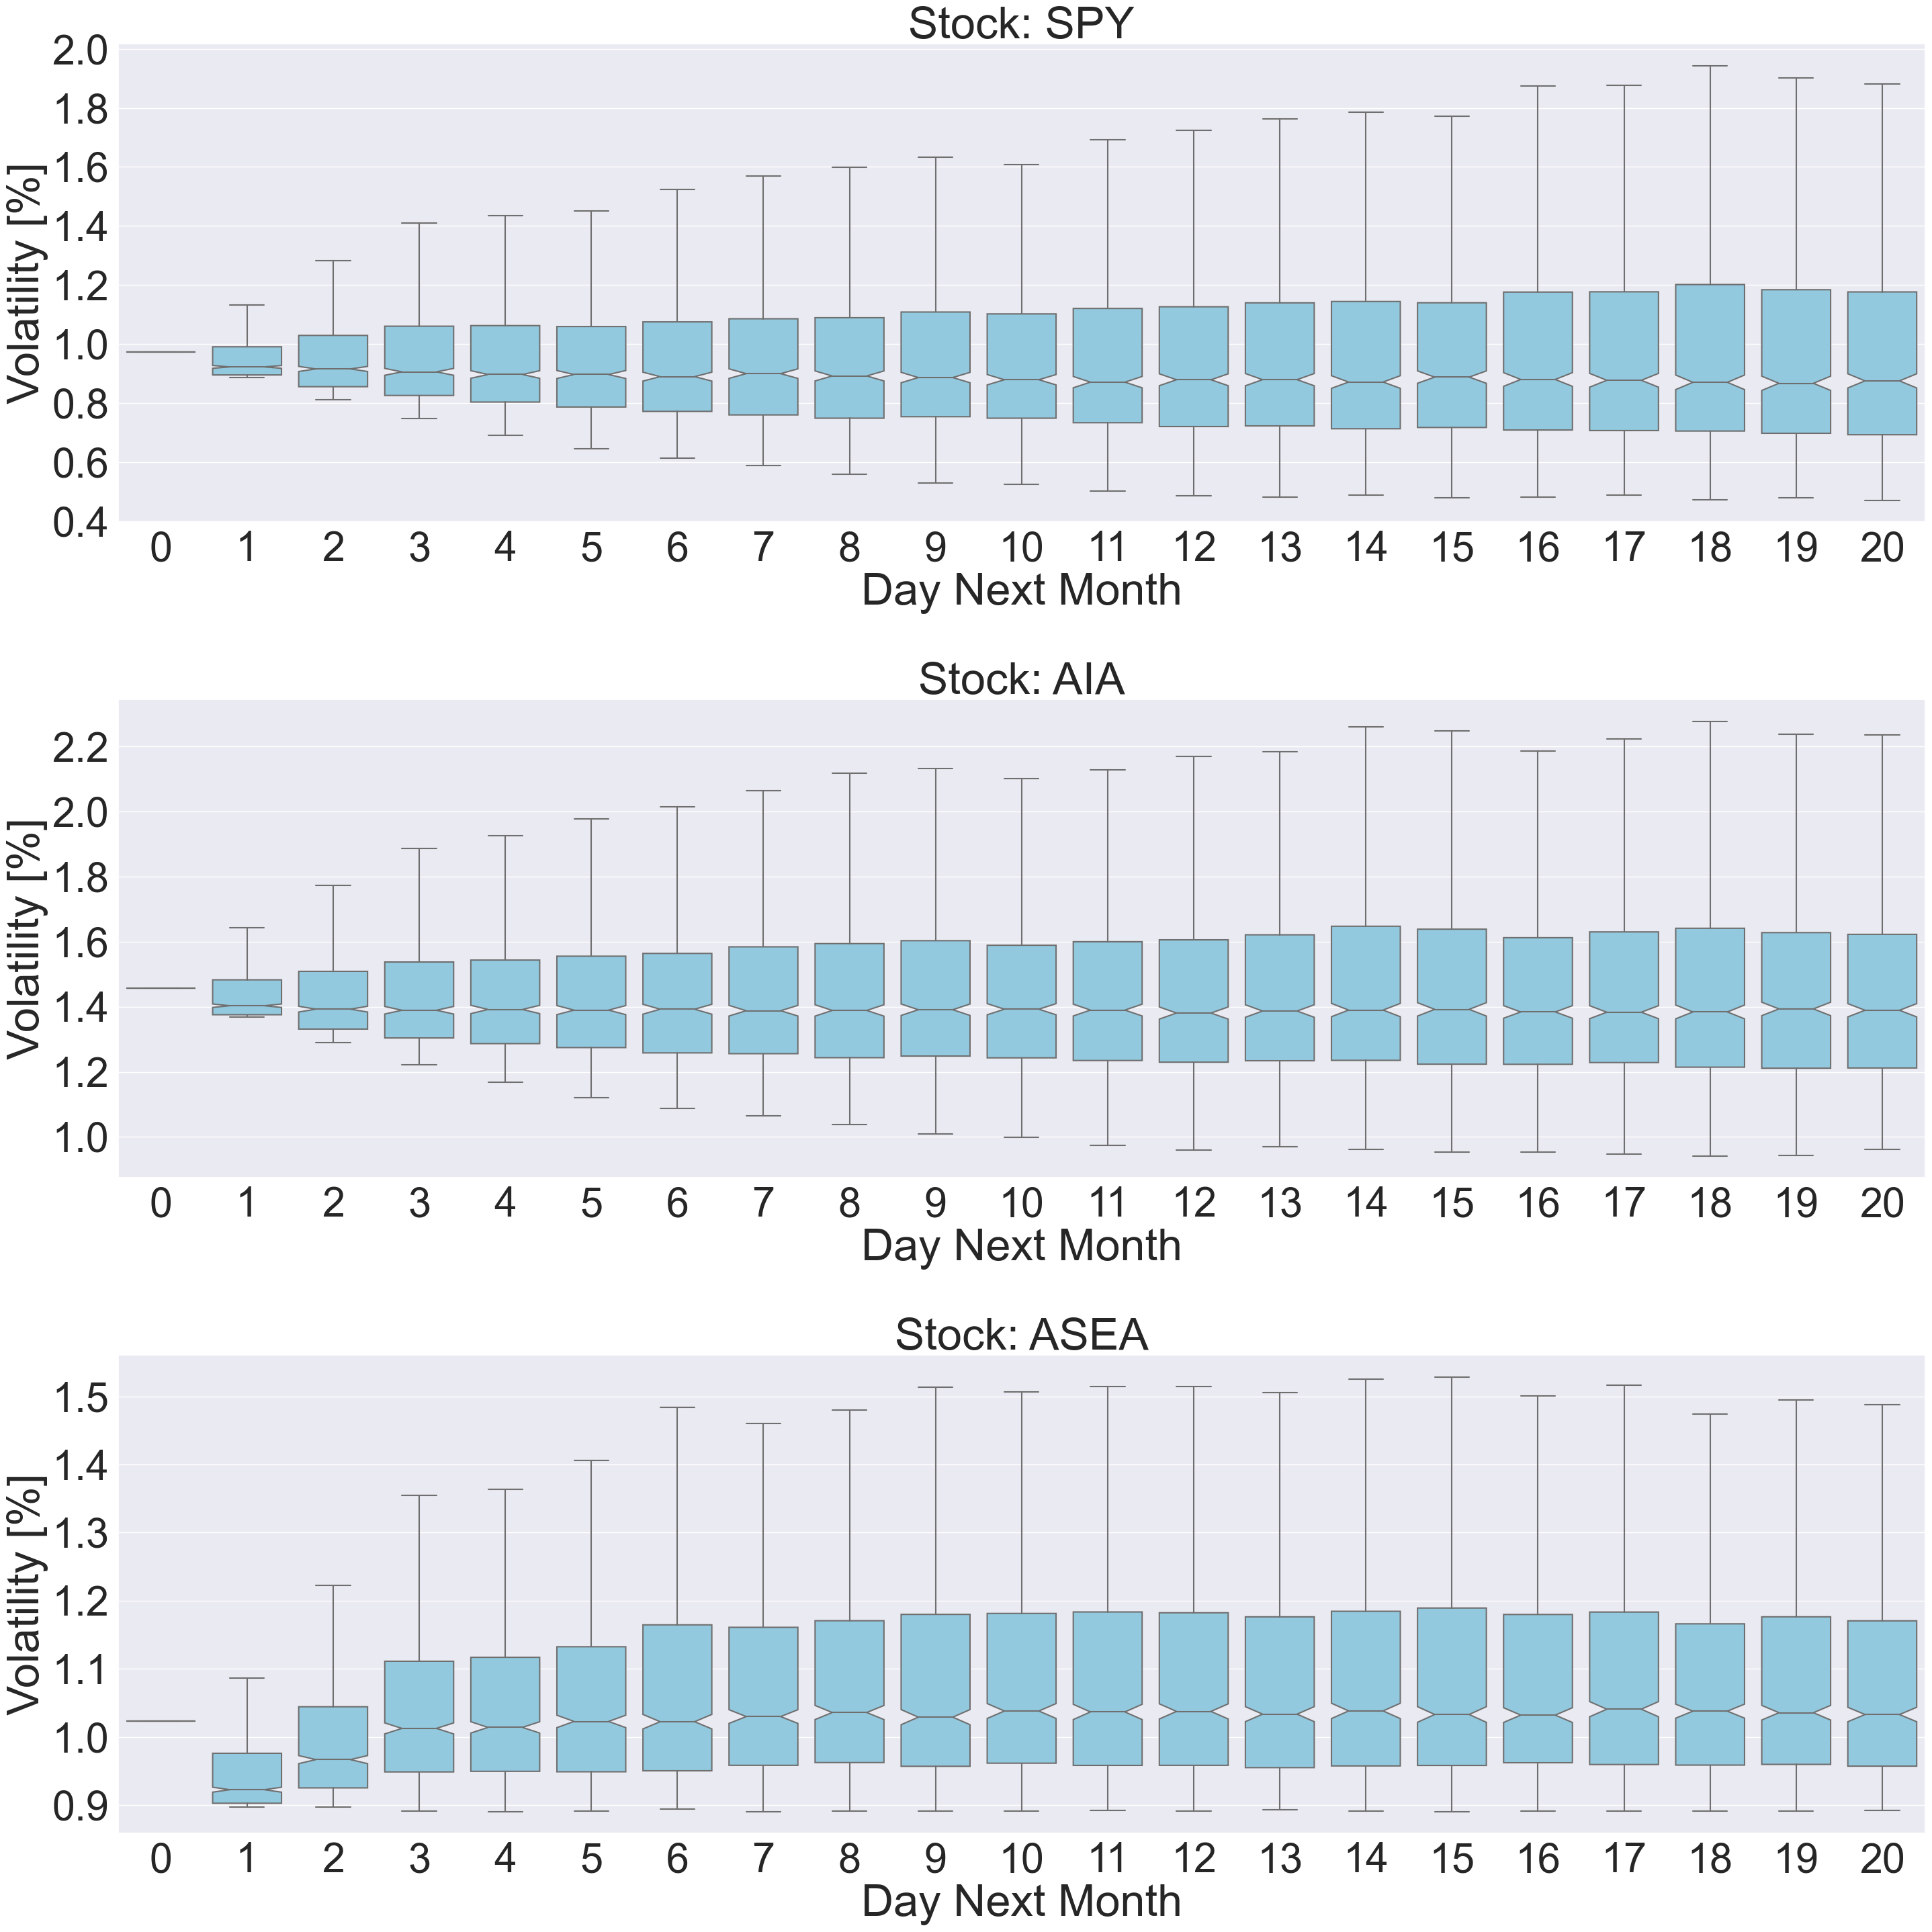

In [44]:
fig=plt.figure(figsize=(30,30))
sns.set(font_scale=4)
for index, stock_name in enumerate(stock_list):
    fig_num = int('31' + str(index + 1))
    fig.add_subplot(fig_num)
    plot_name = 'Stock: ' + stock_name 
    plt.title(plot_name)
    variances_sqroot = forecast_next_month(stock_name,plot=False)
    sns.boxplot(data=variances_sqroot, showfliers = False, notch=True, color='skyblue')    
    plt.savefig('vol_next_21_'+stock_name+'.pdf')
    plt.xlabel('Day Next Month')
    plt.ylabel('Volatility [%]')
fig.tight_layout()
sns.set(font_scale=1)

filename = 'vol_next_month'#+'.pdf'
plt.savefig(filename,bbox_inches = 'tight')

The notches in the box plots mark 95% confidence intervals. Note that in GARCH models, the first step forecasts (day 0 of the next month) is deterministic, meaning that it has no confidence interval!  

# Future improvements and directions

There are some aspects of the project that can be improved or explored further in the future, here are some of them:

#### Modelling asymmetric responses:
The GARCH model assumes that the stock volatilities have symmetric response, meaning that the volatilities change symmetrically irrespective of whether the stock prices increase or decrease. In reality, stock volatilities tend to rise higher when the stock price drops than if it rises by an equal magnitude – the volatility index VIX tend to move up when the S&P 500 falls down. A more complicated model like the Glosten-Jagannathan-Runkle
(GJR)-GARCH can be used to model this effect. 

#### Modelling seasonal effects:
We saw hints of seasonality in the ASEA ETF for what might be seasonal effects with a seasonal lag=3. These kinds of behaviors can be modelled by creating more complex models. 

#### More geographical samples:
We performed our analysis for ETFs in three geographical areas. If we are interested in how market volatilities in different geographical regions behave, we can perform the same procedure to ETFs in different geographical regions. 

#### More complex non-linear models:
GARCH assumes a linear relationship between the conditional variance, its lagged values, and the lagged squared errors. In reality, there could be more complex relationships between these quantities. By treating the lagged variances and squared errors as features, non-linear machine learning techniques (e.g., gradient boosted trees) can be used to try model these non-linear relationships.

#### Modelling relationships between the volatilities:
Now that we have obtained a time series for the volatilities, it might be interesting to seek relationships between the volatilities in different geographical regions. It might also be interesting to find similar relationships between the time series of market volatilities in a certain geographical region with other time-series pertinent to that locale (e.g., the COVID-19 cases/immunization time series in different regions, local temperatures, etc). This could be done through modelling with vector autoregression or more complex non-linear models. 